#Data Preparation

In [ ]:
!pip install z3-solver

     |████████████████████████████████| 30.5MB 143kB/s 


In [ ]:
#importing some libraries that are required
import numpy as np
import math
import matplotlib.pyplot as plt
import random
from random import randint
import tensorflow as tf
import pandas as pd
from tensorflow import keras 
from itertools import chain
from keras import backend
from z3 import *
import math

##The signal configuration

$\sigma = \sqrt{\frac{A^2}{10^\frac{SNR_{db}}{10}}}$

---

In [ ]:
#defining the Signal-to-noise ratio for calculating the sigma(i.e., the noise added to a signal)
SNR=25
SNR_db=10*math.log10(SNR)
sigma = 1/(math.sqrt(math.pow(10,SNR_db/10)))




$S = A .sin(2\pi ft + \varphi) + \Omega(t)$

---


In [ ]:
A=1   #The amplitude is fixed at 1 unit 

S_rate = 24000 #sampling rate
T=1/S_rate  #the time lapsed between two sampling points
N = 500
t= N*T #the time upto which the signal is captured

print(N)
t_seq = np.arange(N) * T #a list with all the time stamps of the sampling points

# this function creates a signal when fed with some frequency and phase
# the time period between two sampling points is 1/24000 sec
# the number of sampling points captured by the signal is 500
# the function returns these 500 points that depicts the signal of a given configuration

def signal(freq,A=1,phi=0):
  y = A*np.sin(2*math.pi*freq*t_seq + phi)
  return y

500


In [ ]:
# Here we define the frequency range of our signal
lrange = 1000  #This is the lower bound of the frequency range 
urange = 5000  #This is the upper bound of the frequency range

In [ ]:
#Here we generate signals without adding any noise
dataset_wo_noise = [[]]
for freq in range(lrange,urange):
  y = signal(freq)   #noise-less signal of size 500
  y = y.tolist()
  dataset_wo_noise.append([y,[freq]])
dataset_wo_noise=dataset_wo_noise[1:] #removes a blank in the 0th element

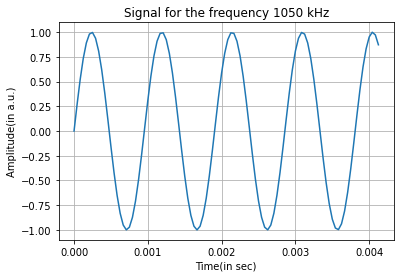

In [ ]:
plt.plot(t_seq[:100],dataset_wo_noise[50][0][:100])
plt.ylabel("Amplitude(in a.u.)")
plt.xlabel("Time(in sec)")
plt.grid()
plt.title("Signal for the frequency 1050 kHz")
plt.show()

Adding Noise to the Signal using Gaussian Distribution

In [ ]:
#This function takes a signal and a Signal-to-noise ratio and the uses gaussian distribution to 
#to feed noise into the signal
def Adding_noise(signal,SNR_db):
  # Set a target SNR
  # Calculate signal power and convert to dB 
  sig_avg = np.mean(signal)
  if(sig_avg > 0):
    sig_avg_db = 10 * np.log10(abs(sig_avg))
  else:
    sig_avg_db = 0
  #print(sig_avg_db)
  # Calculate noise then convert
  noise_avg_db = sig_avg_db - SNR_db
  noise_avg = 10 ** (noise_avg_db / 10)
  # Generate an sample of white noise
  mean_noise = 0
  noise = np.random.normal(mean_noise, np.sqrt(noise_avg), len(signal))
  # Noise up the original signal
  return (signal + noise).tolist()

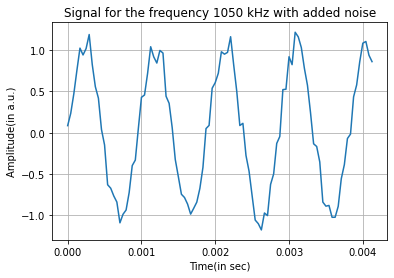

In [ ]:
#Checking a signal after adding noise
plt.plot(t_seq[:100],Adding_noise(dataset_wo_noise[50][0][:100],SNR_db/2))
plt.ylabel("Amplitude(in a.u.)")
plt.xlabel("Time(in sec)")
plt.grid()
plt.title("Signal for the frequency 1050 kHz with added noise")
plt.show()

In [ ]:
#Taking the previously generated dataset and adding noise to each signal
dataset_with_noise = [[]]
for data in dataset_wo_noise:
  dataset_with_noise.append([Adding_noise(data[0],SNR_db),data[1]])
dataset_with_noise=dataset_with_noise[1:]
print(len(dataset_with_noise))

4000


Generating 50 sampling data from the signals(of length 500)

This is done in order to have the dataset with varying phase

In [ ]:
#This is for the signal with noise
#Here we take a randomly some consecutive 50 points from the signal of 500 sampling points
sampled_dataset_with_noise=[[]]
no_of_sampling_data = 50 # this is the number of phase shifted data we are taking from each data of the dataset
for i in dataset_with_noise:
  #Taking 50 such sampling data with varying phase
  for j in random.sample(range(0, len(dataset_with_noise[0][0])-no_of_sampling_data), 50):
    sampled_dataset_with_noise.append([i[0][j:j+no_of_sampling_data],i[1]])
sampled_dataset_with_noise=sampled_dataset_with_noise[1:]
len(sampled_dataset_with_noise)

200000

In [ ]:
#This is for the signal w/o noise
#Here we take a randomly some consecutive 50 points from the signal of 500 sampling points
sampled_dataset_wo_noise=[[]]
for i in dataset_wo_noise:
  #Taking 50 of such sampling data with varying phase
  for j in random.sample(range(0, len(dataset_wo_noise[0][0])-no_of_sampling_data), 50):
    sampled_dataset_wo_noise.append([i[0][j:j+no_of_sampling_data],i[1]])
sampled_dataset_wo_noise=sampled_dataset_wo_noise[1:]
len(sampled_dataset_wo_noise)

200000

In [ ]:
#The total dataset
dataset = sampled_dataset_with_noise
#To Include bias
for data in dataset:
    data[0].append(1)

In [ ]:
len(dataset)

200000

#The Neural Network

In the following section, We take the dataset and divide it into Training(70%), Validating(20%) and Testing data(10%). 

In [ ]:
# Creating a dataframe 
df = pd.DataFrame(dataset.copy()) 
# Creating a dataframe with 70% 
# values of original dataframe 
part_70 = df.sample(frac = 0.7) 
print(np.array(part_70).shape)
# Creating dataframe with 20%
# from rest of the 30% values 
part_30 = df.drop(part_70.index)
part_10 = part_30.sample(frac = 1/3)
print(np.array(part_10).shape)
# Creating dataframe with 10%
part_20 = part_30.drop(part_10.index)
print(np.array(part_20).shape)

(140000, 2)
(20000, 2)
(40000, 2)


Now, we prepare the 3 datasets by reshaping them such that they comply with the tensor flow standards and divide into input and output parts as X_ and Y_ respectively and normalize the output data.

In [ ]:
#A function that is required to normalize the output frequency
def norm(val):
  return (val-lrange)/(urange-lrange)
def denorm(val):
  return (val*(urange-lrange))+lrange

In [ ]:
#reshaping the data and splitting into input and output data
x_train=np.hstack(np.delete(np.array(part_70),-1,axis=1))
x_train=np.hstack(x_train).reshape(len(part_70),no_of_sampling_data+1,1)
#print(len(x_train[0]))
y=np.delete(np.array(part_70),slice(1),axis=1)
y=np.hstack(y)
y_t = [norm(j) for sub in y for j in sub]
y_train=np.hstack(y_t).reshape(len(part_70),-1)
#print(y_train)

x_val=np.hstack(np.delete(np.array(part_20),-1,axis=1))
x_val=np.hstack(x_val).reshape(len(part_20),no_of_sampling_data+1,1)
#print(x_val)
y1=np.delete(np.array(part_20),slice(1),axis=1)
y1=np.hstack(y1)
y_t1 = [norm(j) for sub in y1 for j in sub]
y_val=np.hstack(y_t1).reshape(len(part_20),-1)
#print(y_val)

x_test=np.hstack(np.delete(np.array(part_10),-1,axis=1))
x_test=np.hstack(x_test).reshape(len(part_10),no_of_sampling_data+1,1)
#print(x_test)
y2=np.delete(np.array(part_10),slice(1),axis=1)
y2=np.hstack(y2)
y_t2 = [norm(j) for sub in y2 for j in sub]
y_test=np.hstack(y_t2).reshape(len(part_10),-1)


Here, We define the Neural Network Model.

In [ ]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(no_of_sampling_data+1,1)),
    keras.layers.Dense(units=9, activation='relu',use_bias=False),
    keras.layers.Dense(units=1, activation='relu',use_bias=False)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 51)                0         
_________________________________________________________________
dense (Dense)                (None, 9)                 459       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 468
Trainable params: 468
Non-trainable params: 0
_________________________________________________________________


Training the Model with Adam Optimizer and using mean-squared error loss function and over 100 epochs.

In [ ]:

def acc_net(y_true, y_pred,thresh=0.05):
	return backend.sqrt(backend.mean(float(abs(denorm(y_pred) - denorm(y_true))<=thresh*denorm(y_true)), axis=-1))
opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer="adam", 
              loss="mean_squared_error", metrics=[acc_net])
epoch = 5
history = model.fit(x_train, y_train,epochs=20,validation_data=(x_val,y_val))

Epoch 1/20
4375/4375 [==============================] - 6s 1ms/step - loss: 0.0431 - acc_net: 0.3726 - val_loss: 0.0013 - val_acc_net: 0.7797
Epoch 2/20
4375/4375 [==============================] - 5s 1ms/step - loss: 0.0011 - acc_net: 0.8024 - val_loss: 7.0227e-04 - val_acc_net: 0.8508
Epoch 3/20
4375/4375 [==============================] - 5s 1ms/step - loss: 7.1642e-04 - acc_net: 0.8485 - val_loss: 6.7092e-04 - val_acc_net: 0.8520
Epoch 4/20
4375/4375 [==============================] - 5s 1ms/step - loss: 6.0817e-04 - acc_net: 0.8581 - val_loss: 5.8692e-04 - val_acc_net: 0.8519
Epoch 5/20
4375/4375 [==============================] - 5s 1ms/step - loss: 5.6866e-04 - acc_net: 0.8657 - val_loss: 6.3077e-04 - val_acc_net: 0.8422
Epoch 6/20
4375/4375 [==============================] - 5s 1ms/step - loss: 5.4894e-04 - acc_net: 0.8653 - val_loss: 5.1119e-04 - val_acc_net: 0.8667
Epoch 7/20
4375/4375 [==============================] - 5s 1ms/step - loss: 5.2345e-04 - acc_net: 0.8735 - val_l

Plotting Model Accuracy over Training and Validation data

dict_keys(['loss', 'acc_net', 'val_loss', 'val_acc_net'])


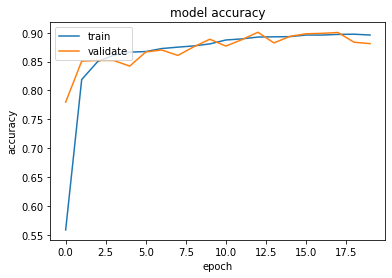

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc_net'])
plt.plot(history.history['val_acc_net'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

Plotting Model Loss over Training and Validation data

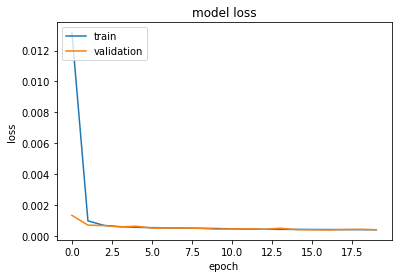

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

The following function calculates the accuracy of the model for a given threshold.

 [Note: calculating accuracy w/o threshold is impossible for regression problems]

In [ ]:
def network_accuracy(output,y_test, thresh):
  #print(list([denorm(out) for out in output[:10]]))
  #print(list([denorm(out) for out in y_test[:10]]))
  p = [abs(denorm(out)-denorm(y))<=thresh*denorm(out) for y,out in zip(y_test,output)]
  #print(p)
  s =[int(a.flatten()) for a in p]
  #print(s)
  return (np.array(s).sum())/(len(y_test))*100.0


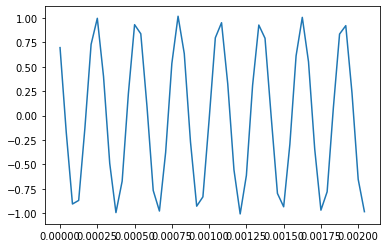

[[3592.39]]
[3618.]


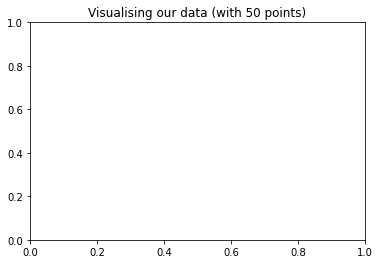

In [ ]:
k = 211
plt.plot(t_seq[:50], x_test[k][:-1])
plt.show()
plt.title("Visualising our data (with 50 points)")
out = model.predict(x_test[k:k+1])
print(denorm(out))
print(denorm(y_test[k]))


Plotting original and Predicted Signal for a Low frequency

In [ ]:
D=[1224.7,4129.1]
c1=random.sample(range(250),1)
c1=c1[0]
print(c1)
s=signal(1224.7)
D_f=Adding_noise(s[c1:50+c1],SNR_db)
print(D_f)
D_f.append(1.0000)
print(D_f)
test_fre=[]
test_fre.append(D_f)
c2=random.sample(range(250),1)
c2=c2[0]
print(c2)
s=signal(4129.1)
D_f=Adding_noise(s[c2:50+c2],SNR_db)
D_f.append(1)
test_fre.append(D_f)


66
[1.0319372583181692, 0.8670397522682323, -0.0017548350413029434, -0.39034359867313645, -0.27890976834430226, -0.38224509912288573, -0.8440281127455556, -1.137191373672185, -1.3227060025403707, -1.0962273985665774, -0.4731411859289192, -0.1720354737452996, 0.3277717110711687, 0.15551824344694457, 0.15805243390478174, 0.357324498887343, 0.6770450820656019, 0.8218231368081973, 0.8741220001380404, 0.8851184489967494, 0.7745296980262533, 0.36602132185944286, -0.22987668878618805, -0.3815600136608982, -0.49710334937065265, -1.147840123340126, -0.8864335710009372, -1.2653860813543951, -1.2159903649357262, -0.7523018194652644, -0.8183259117128175, -0.23330406571529422, -0.37475281335895266, -0.010907470724392354, 0.7529368999109682, 1.2642226429895118, 0.5240385424895044, 1.0201468987239126, 0.9603709991186795, 0.7968650593091336, -0.04369178011896968, 0.0828811308537766, 0.008918179098487883, -0.12955306595051153, -0.9885124966708996, -0.5774870408357353, -0.9525518737121541, -1.0051238856

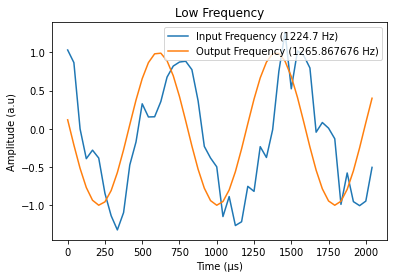

In [ ]:
p=model.predict(test_fre)
plt.plot(t_seq[:50]*1000000,test_fre[0][:-1] ,label='Input Frequency (1224.7 Hz)')
plt.plot(t_seq[:50]*1000000, signal(denorm(p[0]))[c1:50+c1],label='Output Frequency (%f Hz)'%denorm(p[0]))
plt.title("Low Frequency")
plt.xlabel("Time (μs)")
plt.ylabel("Amplitude (a.u)")
plt.legend(loc='upper right')
plt.show()



Plotting original and Predicted Signal for a High frequency

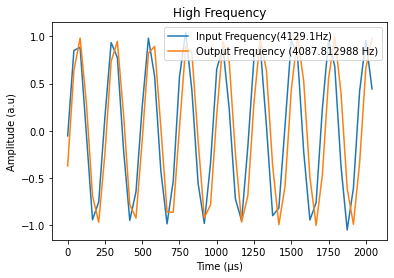

In [ ]:
plt.plot(t_seq[:50]*1000000,test_fre[1][:-1] ,label='Input Frequency(4129.1Hz)')
plt.plot(t_seq[:50]*1000000, signal(denorm(p[1]))[c2:50+c2],label='Output Frequency (%f Hz)'%denorm(p[1]))
plt.title("High Frequency")
plt.xlabel("Time (μs)")
plt.ylabel("Amplitude (a.u)")
plt.legend( loc='upper right')
plt.show()

Now, We test the model over the testing data and check its loss and accuracy.

In [ ]:
model.evaluate(x_test,y_test)
output = model.predict(x_test)

print("Accuracy:",network_accuracy(output,y_test, 0.05))

625/625 [==============================] - 1s 850us/step - loss: 3.9931e-04 - acc_net: 0.8776
Accuracy: 87.225


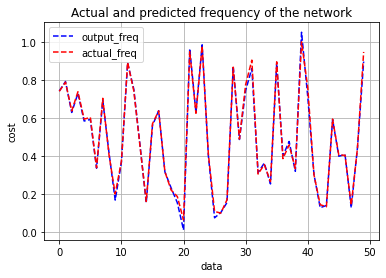

In [ ]:
plt.plot([i for i in range (0,50)] ,output[:50],'b--',label="output_freq")
plt.plot([i for i in range (0,50)] ,y_test[:50],'r--',label="actual_freq")
plt.xlabel("data")
plt.ylabel("cost")
plt.legend()
plt.grid()
plt.title("Actual and predicted frequency of the network")
plt.show()

In the following section, We capture all the weights and biases for each layer of the trained model

In [ ]:
layers = []
for layer in model.layers:
    layers.append(layer.get_weights())

In [ ]:
weights = [layers[1][0].transpose()]
for i in range(2,len(model.layers)):
  layer_weights = layers[i][0].transpose()
  weights += [layer_weights]

In [ ]:
def lists_to_array(c):
    output=[]
    for i in c:
        k=[]
        for j in i:
            k.append(np.array([j]))
        k=np.array(k)
        output.append(k)
    return np.array(output)

# Some necessary Z3 functions

##Feed forward Neural Network

In [ ]:
def multiply_matrix(A, B):
    """
    Assuming valid matrix dimensions
    """
    result = [[0 for j in range(len(B[0]))] for i in range(len(A))]
    for i in range(len(A)): 
        for j in range(len(B[0])): 
            for k in range(len(B)):
                result[i][j] += A[i][k] * B[k][j]
    return result
    
#1-D matrix
def add_matrix(A, B):
    result = [0 for i in range(len(A))]
    for i in range(len(A)):  
        result[i] = A[i] + B[i]
    return result

def apply_relu(out):
    """
    Returns a new z3 list of variables on which relu is applied with name
    """
    curr = [[z3.If(i[0]>0, i[0], 0)] for i in out]
    return curr

def feedforward_z3(weights, x_z3,sol,opt):
    """
    Return the output of the network for the input 'x' which is a list of z3 variables
    """
    
    layered_output = list()
    out = x_z3
    count = 1
    for w in weights:
        #print("Working on layer:", count, "...")
        out0 = multiply_matrix(w, out)
        #out1 = add_matrix(out0, b)
        if(count<len(weights)):
            out = apply_relu(out0)
        else:
            out=out0.copy()
        layered_output.append(out)
        count += 1
    return out

def absol_z3(val):
  return If(val < 0, -1*val, val) 

def get_solver_mod(weights): # for relu activation on each layer
    ## input shape can be obtained by the first weights matrix and output shape by the last weights matrix
    print("Working on model............")
    sol1 = z3.Solver()
    opt1 =z3.Optimize()
    #print("weights:\n",weights)
    inp_size = len(weights[0][0])  ### number of columns in the first row of the first matrix
    out_size = len(weights[-1]) ### number of rows in the last weight matrix
    inp_z31 = [[Real('x1_' + str(i))] for i in range(inp_size)]
    inp_z32 = [[Real('x2_' + str(i))] for i in range(inp_size)]
    out_z31 = [[Real('y1_' + str(i))] for i in range(out_size)]
    out_z32 = [[Real('y2_' + str(i))] for i in range(out_size)]
    res1 = feedforward_z3(weights, inp_z31, sol1,opt1)
    res2 = feedforward_z3(weights, inp_z32, sol1,opt1)
    for i in range(len(out_z31)):
        sol1.add(res1[i][0] == out_z31[i][0])
        sol1.add(res2[i][0] == out_z32[i][0])
    return sol1,inp_z31,inp_z32, out_z31,out_z32

def get_solver(weights): # for relu activation on each layer
    ## input shape can be obtained by the first weights matrix and output shape by the last weights matrix
    print("Working on model............")
    sol = z3.Solver()
    opt=z3.Optimize()
    inp_size = len(weights[0][0])  ### number of columns in the first row of the first matrix
    out_size = len(weights[-1]) ### number of rows in the last weight matrix
    inp_z3 = [[Real('x_' + str(i))] for i in range(inp_size)]
    out_z3 = [[Real('y_' + str(i))] for i in range(out_size)]
    res = feedforward_z3(weights, inp_z3, sol,opt)
    for i in range(len(out_z3)):
        sol.add(res[i][0] == out_z3[i][0])
        opt.add(res[i][0] == out_z3[i][0])
    return opt,sol, inp_z3, out_z3
    ## let us calculate the output layer by layer using the weights and biases with relu activation

##Abstraction of Neural Network

###Splitting to pos and neg

In [ ]:
#segregating neurons into pos and neg based on weights
def posneg(weights):
    new_weights=[]
    new_weights.append(weights[0])
    pos_of_prev=0 # position of previous weight
    L=[] #list of pos and neg in network 
    for weight in weights[1:]:
        num_of_rows=len(weight)
        mod_weight=[]
        pre_weight=[]
        l=[]   #list of pos or neg in each layer
        for i in range(len(weight[0])): # weight[0]: num of columns
            pos=[]   # list of rows in a given column with positive value
            neg=[]   # list of rows in a given column with negative value
            for j in range(num_of_rows):
                if(weight[j][i]>0):
                    pos.append(weight[j][i])
                    #l.append()
                    neg.append(0)
                    
                if(weight[j][i]<=0):
                    neg.append(weight[j][i])
                    pos.append(0)
            #After going through a particular column            
            if (sum(pos)!=0 and sum(neg)!=0): # this column contains both positive and negative values
                mod_weight.append(pos)
                mod_weight.append(neg)
                l.append('P')
                l.append('N')
                pre_weight.append(new_weights[-1][i])
                pre_weight.append(new_weights[-1][i])
            elif(sum(pos)>0):
                mod_weight.append(pos)
                l.append('P')
                pre_weight.append(new_weights[-1][i])
            else :
                l.append('N')
                mod_weight.append(neg)
                pre_weight.append(new_weights[-1][i])
        new_weights=new_weights[:-1]
        new_weights.append(pre_weight)
        new_weights.append(list(np.transpose(mod_weight)))
        L.append(l)
    return [np.array(i)for i in new_weights],L

#segrgating neurons as inc and decrement based on its effect on output

for i in weights:
  print(i,"\n")
print("\n")
print("weights :",type(weights))
print("weights[0]: ",type(weights[0]))
for i in posneg(weights)[0]:
  print(i,"\n")
n,L=posneg(weights)
print("new_weights :", type(n))
print("new_weights[0]",type(n[0]))
print(L)


[[-7.86493197e-02 -2.13500455e-01 -9.98516455e-02  9.74045321e-02
  -1.58714324e-01 -2.68795669e-01 -1.58881005e-02  2.86820650e-01
   6.51399568e-02 -3.20482582e-01 -4.02700275e-01  7.34473690e-02
   3.76571089e-01  2.46057808e-01 -2.27791712e-01 -4.52096641e-01
  -2.25983992e-01  2.77641833e-01  5.14938951e-01  7.11517408e-02
  -2.51180947e-01 -3.80780995e-01  1.86133515e-02  6.00144900e-02
   3.20306957e-01  1.90070346e-01  2.84208301e-02 -1.73427507e-01
  -1.84675202e-01  7.20669776e-02  3.49198222e-01  1.50074750e-01
  -1.64127395e-01 -2.31773019e-01 -5.37139422e-04  3.53886902e-01
   1.40254989e-01 -2.28565201e-01 -3.90577108e-01  9.79837924e-02
   1.99450448e-01  1.34575188e-01 -3.05363417e-01 -3.03635001e-01
   1.40998198e-03  2.68922567e-01  9.95925888e-02 -1.58367991e-01
  -1.31817311e-01  2.05946341e-03  2.93693673e-02]
 [ 7.18164220e-02 -2.94906483e-03 -4.29574102e-02  6.15971489e-03
   9.17037949e-02  2.75903884e-02 -8.24810639e-02 -1.26033321e-01
   3.30562815e-02  1.0344

In [ ]:
L

[['P', 'P', 'N', 'N', 'P', 'N', 'N', 'N', 'P']]

###splitting to inc and dec

In [ ]:
def incdec(pnweights,L): #npweights: weights returned from posneg function
    new_weights=pnweights[-3:]
    '''print("NW\n")
    for i in new_weights:
      print(i,"\n")
    print("\n")'''
    L1=[] #stores status(I/D P/N) for each neuron
    flag=[] # stores the status for neurons of a single layer
    for i in L[-1]: 
      if i == 'P':
        flag.append('PI')
      else:
        flag.append('ND')
    L1.append(flag) # stores the status of the last layer
    #print(flag)
    #print(L1[-1][0][1])
    #print(pnweights[2:-1])
    for weight in reversed(pnweights[2:-1]): # for each weight matrix starting from the penultimate layer
      num_of_rows=len(weight)   #the number of neurons in the next layer
      '''print(len(weight[0]))
      print(new_weights[0])'''
      mod_weight=[]
      pre_weight=[]
      flag=[]
      for i in range(len(weight[0])): # for each neurons of the current layer
        #Status lists
        PI = []
        PD = []
        NI = []
        ND = []
        for j in range(num_of_rows): #for each outgoing edge of each neuron in the current layer
          if weight[j][i] >= 0 and L1[-1][j][1]=='I':
            PI.append(weight[j][i])
            PD.append(0)
            NI.append(0)
            ND.append(0)
          elif weight[j][i] >= 0 and L1[-1][j][1]=='D':
            PI.append(0)
            PD.append(weight[j][i])
            NI.append(0)
            ND.append(0)
          elif weight[j][i] < 0 and L1[-1][j][1]=='I':
            PI.append(0)
            PD.append(0)
            NI.append(weight[j][i])
            ND.append(0)
          elif weight[j][i] < 0 and L1[-1][j][1]=='D':
            PI.append(0)
            PD.append(0)
            NI.append(0)
            ND.append(weight[j][i])
        #end of 3rd loop
        if sum(PI)!=0:
          mod_weight.append(PI)
          pre_weight.append(new_weights[0][i])
          flag.append('PI')
        if sum(PD)!=0:
          mod_weight.append(PD)
          pre_weight.append(new_weights[0][i])
          flag.append('PD')
        if sum(NI)!=0:
          mod_weight.append(NI)
          pre_weight.append(new_weights[0][i])
          flag.append('NI')
        if sum(ND)!=0:
          mod_weight.append(ND)
          pre_weight.append(new_weights[0][i])
          flag.append('ND')
      #end of 2nd loop
      new_weights = new_weights[2:]
      new_weights.insert(0,list(np.transpose(mod_weight)))
      new_weights.insert(0,pre_weight)
      L1.append(flag)
      '''print("weight=\n",weight)
      print("NW\n")
      for i in new_weights:
        print(i,"\n")
      print("\n")'''
    L1 = reversed(L1)
    return [np.array(i)for i in new_weights],list(L1)

for i in weights[1:]:
  print(i,"\n")
print("\n")

n2,L2=posneg(weights)
for i in n2[1:]:
  print(i,"\n")
print("\n")

n,L=incdec(n2,L2)
print("weights :",type(weights))
print("weights[0]: ",type(weights[0]))
for i in n:
  print(i,"\n")
print("new_weights :", type(n))
print("new_weights[0]",type(n[0]))
print(L)


[[ 0.04836517  0.26521924 -0.1745402  -0.11250338  0.16731264 -0.08522598
  -0.08521417 -0.07621374  0.11354655]] 



[[ 0.04836517  0.26521924 -0.1745402  -0.11250338  0.16731264 -0.08522598
  -0.08521417 -0.07621374  0.11354655]] 



weights : <class 'list'>
weights[0]:  <class 'numpy.ndarray'>
[[-7.86493197e-02 -2.13500455e-01 -9.98516455e-02  9.74045321e-02
  -1.58714324e-01 -2.68795669e-01 -1.58881005e-02  2.86820650e-01
   6.51399568e-02 -3.20482582e-01 -4.02700275e-01  7.34473690e-02
   3.76571089e-01  2.46057808e-01 -2.27791712e-01 -4.52096641e-01
  -2.25983992e-01  2.77641833e-01  5.14938951e-01  7.11517408e-02
  -2.51180947e-01 -3.80780995e-01  1.86133515e-02  6.00144900e-02
   3.20306957e-01  1.90070346e-01  2.84208301e-02 -1.73427507e-01
  -1.84675202e-01  7.20669776e-02  3.49198222e-01  1.50074750e-01
  -1.64127395e-01 -2.31773019e-01 -5.37139422e-04  3.53886902e-01
   1.40254989e-01 -2.28565201e-01 -3.90577108e-01  9.79837924e-02
   1.99450448e-01  1.34575188e-01 -3.05363

In [ ]:
L

[['PI', 'PI', 'ND', 'ND', 'PI', 'ND', 'ND', 'ND', 'PI']]

In [ ]:
n

[array([[-7.86493197e-02, -2.13500455e-01, -9.98516455e-02,
          9.74045321e-02, -1.58714324e-01, -2.68795669e-01,
         -1.58881005e-02,  2.86820650e-01,  6.51399568e-02,
         -3.20482582e-01, -4.02700275e-01,  7.34473690e-02,
          3.76571089e-01,  2.46057808e-01, -2.27791712e-01,
         -4.52096641e-01, -2.25983992e-01,  2.77641833e-01,
          5.14938951e-01,  7.11517408e-02, -2.51180947e-01,
         -3.80780995e-01,  1.86133515e-02,  6.00144900e-02,
          3.20306957e-01,  1.90070346e-01,  2.84208301e-02,
         -1.73427507e-01, -1.84675202e-01,  7.20669776e-02,
          3.49198222e-01,  1.50074750e-01, -1.64127395e-01,
         -2.31773019e-01, -5.37139422e-04,  3.53886902e-01,
          1.40254989e-01, -2.28565201e-01, -3.90577108e-01,
          9.79837924e-02,  1.99450448e-01,  1.34575188e-01,
         -3.05363417e-01, -3.03635001e-01,  1.40998198e-03,
          2.68922567e-01,  9.95925888e-02, -1.58367991e-01,
         -1.31817311e-01,  2.05946341e-0

In [ ]:
def list_to_dic(L):
    diction = []
    PIF = NDF =NIF=PDF=[]
    for i in L:
        j=0
        dic=dict()
        PI=[]
        ND=[]
        NI=[]
        PD=[]
        for k in i:
            if k == 'PI':
                PI.append(j)
            elif k=='PD':
                PD.append(j)
            elif k=='NI':
                NI.append(j)
            elif k=='ND':
                ND.append(j)
            j=j+1
        dic['PI']=[PI]
        dic['PD']=[PD]
        dic['ND']=[ND]
        dic['NI']=[NI]
        diction.append(dic)
    return (diction)


###Merging

In [ ]:
#function to merge neurons
#weights: weights after splitting using incdec
#incdec: list which denotes if a neuron is PI,NI,PD,ND 
# [[1st layer I's], [2' layer ]]
# to_merge = [[v_11,12]: 0, [21,23,25]:1]
# [[11,12]: 0, [21,23]:1, [25]:1]
def merge_neuron(weights,incdec):
    #print("In merge neuron:\n",weights)
    new_weights=[]
    new_weights.append(weights[0])
    #NOTE: Here we are starting from layer 2 using first first weight matrix
    i=0
    #print(len(incdec),len(weights[1:-1]))
    for l,wt in zip(incdec,weights[1:]):
        num_of_neurons=0
        for key,value in l.items():
            num_of_neurons+=len(value)
        #print("rows: ",len(wt),"\ncol: ",len(wt[0]))
        #print("Layer 1.......")
        weight=np.array([np.array(xi) for xi in wt])
        #print(type(weight[0]))
        #num_neu=len(incdec[i])
        prev_weight=new_weights.pop()
        len_of_rows=len(wt)
        len_of_col=len(wt[0])
        new_weight=np.zeros([len_of_rows,num_of_neurons])

        new_prev_weight=np.zeros([num_of_neurons,len(prev_weight[0])])
        #new_prev_weight=ninf*new_prev_weight
        '''print(type(new_weight[0]))
        print("new_weight shape : ",new_weight.shape)
        print("new_weight",new_weight)
        print("weight.shape: ",weight.shape)
        print("weight: ",weight)'''
        for key,values in l.items():
            if(key=='PI' or key=='NI'):
                #for k in new_weight:
                # k[0]+=
                i=0 #The columns of the matrix
                for clus in values:#Sum of outgoing
                    for c in clus:
                        for j in range(len_of_col):
                            new_prev_weight[i][j]=prev_weight[c][j]
                for clus in values:#Sum of outgoing
                    for c in clus:
                        new_weight[:,i]=np.add(new_weight[:,i],weight[:,c])
                        for j in range(len_of_col):#len of col in this layer is the length of rows in the previous layer
                            if((new_prev_weight[i][j]<=prev_weight[c][j])):
                                new_prev_weight[i][j]=prev_weight[c][j] # Max of incoming
                    i=i+1
            else:
                for clus in values:#Sum of outgoing
                    for c in clus:
                        new_weight[:,i]=np.add(new_weight[:,i],weight[:,c])
                        for j in range(len_of_col):#len of col in this layer is the length of rows in the previous layer
                            if((new_prev_weight[i][j]>=prev_weight[c][j])):
                                new_prev_weight[i][j]=prev_weight[c][j] # Max of incoming
                    i=i+1
        #print("new_prev_weight:\n",new_prev_weight)
        #print("new_weight:\n",new_weight)
        new_weights.append(np.array(new_prev_weight))
        new_weights.append(np.array(new_weight))
        print("Abstracted model obtained:\n",incdec)
    return new_weights,incdec

In [ ]:
L

[['PI', 'PI', 'ND', 'ND', 'PI', 'ND', 'ND', 'ND', 'PI']]

In [ ]:
list_to_dic(L)


[{'ND': [[2, 3, 5, 6, 7]], 'NI': [[]], 'PD': [[]], 'PI': [[0, 1, 4, 8]]}]

In [ ]:
mw=merge_neuron(n,list_to_dic(L))


Abstracted model obtained:
 [{'PI': [[0, 1, 4, 8]], 'PD': [[]], 'ND': [[2, 3, 5, 6, 7]], 'NI': [[]]}]


In [ ]:
len(mw[0][0])

4

In [ ]:
n

[array([[-7.86493197e-02, -2.13500455e-01, -9.98516455e-02,
          9.74045321e-02, -1.58714324e-01, -2.68795669e-01,
         -1.58881005e-02,  2.86820650e-01,  6.51399568e-02,
         -3.20482582e-01, -4.02700275e-01,  7.34473690e-02,
          3.76571089e-01,  2.46057808e-01, -2.27791712e-01,
         -4.52096641e-01, -2.25983992e-01,  2.77641833e-01,
          5.14938951e-01,  7.11517408e-02, -2.51180947e-01,
         -3.80780995e-01,  1.86133515e-02,  6.00144900e-02,
          3.20306957e-01,  1.90070346e-01,  2.84208301e-02,
         -1.73427507e-01, -1.84675202e-01,  7.20669776e-02,
          3.49198222e-01,  1.50074750e-01, -1.64127395e-01,
         -2.31773019e-01, -5.37139422e-04,  3.53886902e-01,
          1.40254989e-01, -2.28565201e-01, -3.90577108e-01,
          9.79837924e-02,  1.99450448e-01,  1.34575188e-01,
         -3.05363417e-01, -3.03635001e-01,  1.40998198e-03,
          2.68922567e-01,  9.95925888e-02, -1.58367991e-01,
         -1.31817311e-01,  2.05946341e-0

###Splitting of neurons

In [ ]:
def splitting_neurons(slt_weights,mg_weights,inp,L):
    #slt_weights: split weights
    #mg_weights: merged weights
    #inp : counter example
    #L : the status for the neurons in slt_weights
    #layer_no is the layer from which a neuron(represented by the neuron_no) is asked to be split
    slt_val=[] # values of neurons at each layer
    slt_val.append(inp)
    for slt_weight in slt_weights:
        v=slt_val[-1]
        v=np.array(v)
        #print("v",v)
        #print(np.transpose(slt_weight))
        v1=np.matmul(slt_val[-1],np.transpose(slt_weight))
        v1=list(v1)
        slt_val.append(v1)
    #print("slt_val :\n",slt_val)
    mg_val=[] # values of neurons at each layer
    mg_val.append(inp)
    for mg_weight in mg_weights:
        v=mg_val[-1]
        v=np.array(v)
        v1=np.matmul(v,np.transpose(mg_weight))
        v1=list(v1)
        mg_val.append(v1)
    #print("mg_val :\n",mg_val)
    max=-np.inf 
    s=-1 # neuron to be splitted in layer lno
    lno=-1 #layer num
    num_layers=len(slt_weights) # num of layer (it is same in both the neural network)
    for i in range (num_layers-1): #considering only hidden layers
        print("In hidden layer: ",i)
        dic=L[i]
        mno=-1 # merged neuron num
        sno=-1 #split neuron num
        for key,val in dic.items():
            #print("we are in key : ",key)
            for v in val:
                #print (" v in val : ",v)
                mno+=1 #neuron under consideration 
                if(len(v)==1):
                    sno=sno+1
                    
                elif(len(v)==0):
                    continue
                elif(len(v)>1): # there are neurons that can be splitted
                    for k in v:
                        #print("Here len of val >1")
                        #sno=sno+1 # sno will be same as k
                        if(max< abs(mg_val[i+1][mno]-slt_val[i+1][k])):
                            max=abs(mg_val[i+1][mno]-slt_val[i+1][k])
                            lno=i
                            s=k
                #print("New found max : ",max)
                #print("New found layer num : ",lno)
                #print("New found neuron num  : ",s)
    new_L=[]
    for l in range (num_layers-1):
        if(l!=lno):
            new_L.append(L[l])
        else:
            my_dic={}
            dic=L[l]
            for key,val in dic.items():
                my_dic[key]=[]
                #print(val)
                for v in val:
                    #print("v: ",v)
                    z=v
                    if (not(s in v)):
                        my_dic[key].append(z)
                        

                    else:
                        #print("v: ",v)
                        #print("s: ",s)
                        z.remove(s)
                        #print("Remaining elements : ",v)
                        my_dic[key].append(z)
                        sl=[s]
                        my_dic[key].append(sl)
                        
            new_L.append(my_dic)
    #print("In splitting neuron L after spliting: ",new_L)
    return (new_L)

In [ ]:
#checking the working of "splitting neurons" by giving a layer number and neuron
L=[{'PI': [[0, 3, 4, 5, 6], [8]], 'PD': [[]], 'ND': [[1, 2, 7]], 'NI': [[]]}]
new_L=[]
num_layers=2
lno=0
s=0
for l in range (num_layers-1):
    print("Inside ")
    if(l!=lno):
        new_L.append(L[l])
    else:
        my_dic={}
        dic=L[l]
        for key,val in dic.items():
            my_dic[key]=[]
            print(val)
            for v in val:
                print("v: ",v)
                z=v
                if (not(s in v)):
                    my_dic[key].append(z)
                    

                else:
                    #print("v: ",v)
                    #print("s: ",s)
                    z.remove(s)
                    #print("Remaining elements : ",v)
                    my_dic[key].append(z)
                    sl=[s]
                    my_dic[key].append(sl)
                    
        new_L.append(my_dic)
print(new_L)

Inside 
[[0, 3, 4, 5, 6], [8]]
v:  [0, 3, 4, 5, 6]
v:  [8]
[[]]
v:  []
[[1, 2, 7]]
v:  [1, 2, 7]
[[]]
v:  []
[{'PI': [[3, 4, 5, 6], [0], [8]], 'PD': [[]], 'ND': [[1, 2, 7]], 'NI': [[]]}]


##CEGAR Algorithm

In [ ]:
def ff(slt_weights,inp):
    slt_val=[] # values of neurons at each layer
    slt_val.append(inp)
    for slt_weight in slt_weights:
        v=slt_val[-1]
        v=np.array(v)
        #print("v",v)
        #print(np.transpose(slt_weight))
        v1=np.matmul(slt_val[-1],np.transpose(slt_weight))
        v1=list(v1)
        slt_val.append(v1)  
    return slt_val[-1]  



In [ ]:
#this class is for verification of Reversal of a wave
class Check:
  def check_func(self,weights):
    #print("check_func:\n",weights)
    tol=0.01
    f= Real('f') #frequency we want to optimise
    #Simulation of the Trained Neural Network
    #complying with Z3
    sol,inp,inp2,out,out2 = get_solver_mod(weights)
    sol.add(inp[50][0]==1)
    sol.add(inp2[50][0]==1)

    for i in range(50): #constraints that the Amplitude is atmost 1
        sol.add(inp[i][0]>=-1)
        sol.add(inp[i][0]<= 1)
        sol.add(inp2[i][0]>=-1)
        sol.add(inp2[i][0]<= 1)

    sol.add(And(f>=4000,f<=5000))
    #time interval between 2 sampling points
    step = 6.28318*f*1/24000
    v1= old_v = 0
    for i in range(50):
        sol.add(inp[i][0] == z3sinx(v1))
        v = Real('v_' + str(i)) #stores the shifted signal
        sol.add(v == (old_v + step))
        v1 = If(v >= 6.28318, v-6.28318, v)
        old_v = v1
    sol.add(absol_z3(denorm(out[0][0])-denorm(out2[0][0])) >= (tol*denorm(out[0][0])))


    for j in range(50):
        sol.add(inp[49-j][0]==inp2[j][0])
    if(sol.check()=='unsat'):
        return ["holds property",0]
    else:
        m = sol.model()
        diction = {"x1_" + str(i): 0 for i in range(51)}
        # print(diction)
        for d in m.decls():
            if d.name() in diction.keys():
                diction[d.name()] = float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))


        lst1 = []
        for i in diction.keys():
            lst1.append(diction[i])

        diction = {"x2_" + str(i): 0 for i in range(51)}
        # print(diction)
        for d in m.decls():
            if d.name() in diction.keys():
                diction[d.name()] = float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))


        lst2 = []
        for i in diction.keys():
            lst2.append(diction[i])

        op = 0
        output = "y2_0"
        for d in m.decls():
            if output in d.name():
                op=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))

        op = 0
        output = "f"
        for d in m.decls():
            if output in d.name():
                q=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
        c_ex=[lst1,lst2,q]
        m=c_ex
        print("Counter example : ", np.array(m[0]))
        #print("Predicted o/p of the Original Model:",q)
        #print("Predicted o/p of the Abstracted Model:",denorm(op))
        return ["Not hold",c_ex]
        
  def check_is_valid(self,weight,cex):
      tol=0.01
      res1=ff(weight,cex[0])
      res2=ff(weight,cex[1])
      res1=res1[0]
      res2=res2[0]
      #print(denorm(res1))
      #print(denorm(res2))
      if(abs(denorm(res1)-denorm(res2))>=tol*denorm(res1)):
          print("Valid counter example")
          return True
      else:
          print("not a valid counter example")
          return False  



    

In [ ]:
def refinement(c_ex,abs_weights,ori_weights,L,check_func,check_is_valid):
    #c_ex: Spurious counter example
    #abs_weights: abstracted neural network
    #ori_weights: equivalent to the original neural network
    #L : List of dict wrt the abstracted neural network
    print("\nWE ARE REFINING.....\n")
    abs=True
    while(abs):
        #print("In refinement L before spliting: ",L)
        split_list= splitting_neurons(ori_weights,abs_weights,c_ex[0],L)
        #print("In refinement L after spliting: ",split_list)
        new_abs_weights,new_L=merge_neuron(ori_weights,split_list)
        #print("in refinement after each merge_neuron : ",new_L)
        abs_weights=new_abs_weights
        L=new_L
        abs=(check_is_valid(abs_weights,c_ex))
    print("\n WE ARE DONE REFINING...........\n")
    return abs_weights,new_L
def cegar(mgweights,idweights,check_obj,l):
    # the abstracted model should be calculated by the cegar loop itself, the input should be the original network

    #mgweights: Abstracted network
    #idweights: original network
    #mgopt,mgsol, mginp_z3, mgout_z3=get_solver(mgweights)
    #idopt,idsol,idinp_Z3, idout_z3=get_solver(idweights)
    check_func=check_obj.check_func
    check_is_valid=check_obj.check_is_valid
    mg_result=check_func(mgweights)
    if(mg_result[0]=="holds property"):
        return "holds property"
    else:
        if (mg_result[0]=="Not hold"):
            if (check_is_valid(idweights,mg_result[1])): #this inp is the actual counter example
                return "Not hold"
            else: #this inp is spurious counter example
                print("In cegar L given to refinement : ",l)
                new_weights,new_L=refinement(mg_result[1],mgweights,idweights,l,check_func,check_is_valid)
                print("In cegar L returned by refinement : ",new_L)
                return (cegar(new_weights,idweights,check_obj,new_L))
def my_cegar(weights,check_obj):
    #weights : weights of the original neural network
    #prop: which we want to check
    #print("my_cegar:\n",weights)
    pnweights,L1=posneg(weights)
    #print("pn:\n",pnweights)
    idweights,L2=incdec(pnweights,L1)
    #print("id: \n",idweights)
    L=list_to_dic(L2)
    mgweights,mgL=merge_neuron(idweights,L) # we are merging it fully so that there is atmost 4 neurons in each layers
    #print("mgweights:\n",mgweights)
    return(cegar(mgweights,idweights,check_obj,mgL))








## Approximation of Sinewave


In [ ]:
for i in range (12):
    print(2*i+1," ",math.factorial(2*i+1))

1   1
3   6
5   120
7   5040
9   362880
11   39916800
13   6227020800
15   1307674368000
17   355687428096000
19   121645100408832000
21   51090942171709440000
23   25852016738884976640000


In [ ]:

def z3sinx(x):
    return x/1 - x**3 /6 +x**5/120 -x**7/5040 + x**9/362880 - x**11/39916800 + x**13/6227020800 -x**15/1307674368000 

def z3mod(v, m):
  return (v - m*(v/m))

def get_sine_approx(f):
  lst = []
  lst_t = [0]
  v=0
  for i in range(50):
      lst_t.append(v)
      lst.append(z3sinx(v))
      v = lst_t[-1] + 6.28318*f*T
      if (v >= 6.28318):
        v = v-6.28318
  return lst

#Comparison of different approximation of inputs

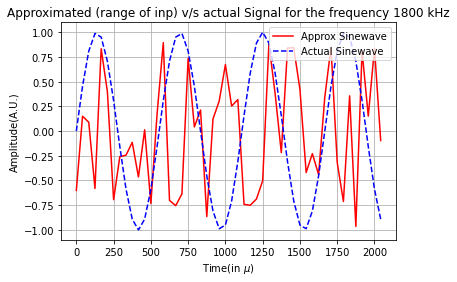

In [ ]:
#comparison of range for inputs with the original wave
inp=[]
for i in range(50):
    sign=random.randint(0,1)
    value=random.uniform(0,1)
    if(sign==0):
        inp.append(value)
    else:
        inp.append(-value)

plt.plot(t_seq[:50]*10**6,inp,'r', label="Approx Sinewave")
plt.plot(t_seq[:50]*10**6, signal(1800)[:50],'b--', label="Actual Sinewave")
plt.xlabel("Time(in $\mu$)")
plt.ylabel("Amplitude(A.U.)")
plt.legend(loc="upper right")
plt.grid()
plt.title("Approximated (range of inp) v/s actual Signal for the frequency 1800 kHz")
plt.show()

In [ ]:
f=1800

f= Real('f') #frequency we want to optimise
sol=Solver()
inp1 = [[Real('x1_' + str(i))] for i in range(50)]
for i in range(50): #constraints that the Amplitude is atmost 1
  sol.add(inp1[i][0]>=-1)
  sol.add(inp1[i][0]<= 1)

# for continuity of input
for i in range(1,50):
    sol.add(absol_z3(inp1[i][0]-inp1[i-1][0])<=0.1*norm(f)*inp1[i][0])
    sol.add(Not(inp1[i-1][0]==inp1[i][0])) # no two consequtive inp is same
    
sol.check()

sat

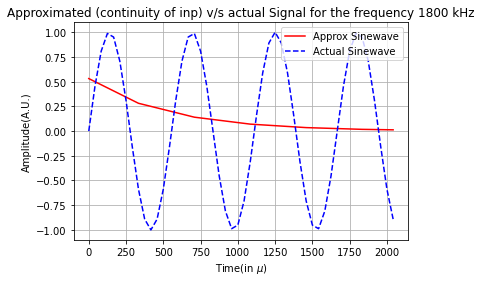

In [ ]:
m = sol.model()
diction = {"x1_" + str(i): 0 for i in range(50)}
# print(diction)
for d in m.decls():
    if d.name() in diction.keys():
        diction[d.name()] = float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))


lst = []
for i in diction.keys():
    lst.append(diction[i])
plt.plot(t_seq[:50]*10**6,lst,'r', label="Approx Sinewave")
plt.plot(t_seq[:50]*10**6, signal(1800)[:50],'b--', label="Actual Sinewave")
plt.xlabel("Time(in $\mu$)")
plt.ylabel("Amplitude(A.U.)")
plt.legend(loc="upper right")
plt.grid()
plt.title("Approximated (continuity of inp) v/s actual Signal for the frequency 1800 kHz")
plt.show()

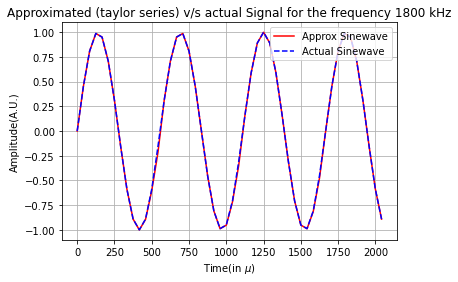

In [ ]:
#Comparison of approximate sine wave with the original wave
plt.plot(t_seq[:50]*10**6, get_sine_approx(1800)[:50],'r', label="Approx Sinewave")
plt.plot(t_seq[:50]*10**6, signal(1800)[:50],'b--', label="Actual Sinewave")
plt.xlabel("Time(in $\mu$)")
plt.ylabel("Amplitude(A.U.)")
plt.legend(loc="upper right")
plt.grid()
plt.title("Approximated (taylor series) v/s actual Signal for the frequency 1800 kHz")
plt.show()
plt.show()

#Verification of properties using range of input

## Phase Change

if there exists a phase change for a given signal, such that the frequency predicted by the network exceeds the threshold.

In [ ]:
tol=0.01
f= Real('f') #frequency we want to optimise
opt,sol,inp,out = get_solver(weights) #Simulation of the Trained Neural Network
                                             #complying with Z3
for i in range(50): #constraints that the Amplitude is atmost 1
  sol.add(inp[i][0]>=-1)
  sol.add(inp[i][0]<= 1)
sol.add(inp[50][0]==1)
sol.add(And(f>=1000,f<=5000)) #range of the frequency
sol.add(absol_z3(denorm(out[0][0])-f) >= (tol*f))
sol.check()

Working on model............


sat

1000
1000
f


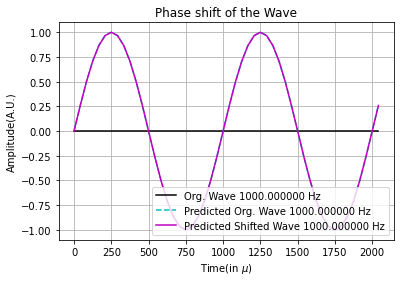

In [ ]:
m = sol.model()
diction = {"x1_" + str(i): 0 for i in range(50)}
# print(diction)
for d in m.decls():
    if d.name() in diction.keys():
        diction[d.name()] = float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))


lst = []
for i in diction.keys():
    lst.append(diction[i])

diction = {"x2_" + str(i): 0 for i in range(50)}
# print(diction)
for d in m.decls():
    if d.name() in diction.keys():
        diction[d.name()] = float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))


lst1 = []
for i in diction.keys():
    lst1.append(diction[i])
f1 = 0
output = "y1_0"
for d in m.decls():
  if output in d.name():
    f1=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
q = 0
output = "f"
for d in m.decls():
  if output in d.name():
    q=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
f2=0
output = "y2_0"
for d in m.decls():
  if output in d.name():
    f2=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
print(denorm(f2))
print(denorm(f1))
print(f)
plt.plot(t_seq[:50]*10**6,lst[:50],'k',label="Org. Wave %f Hz"%q)
plt.plot(t_seq[:50]*10**6,signal(denorm(f1))[:50],'c--',label="Predicted Org. Wave %f Hz"%denorm(f1))
plt.plot(t_seq[:50]*10**6,signal(denorm(f2))[:50],'m',label="Predicted Shifted Wave %f Hz"%denorm(f2))
plt.grid()
plt.xlabel("Time(in $\mu$)")
plt.ylabel("Amplitude(A.U.)")
plt.legend(loc="lower right")
plt.title("Phase shift of the Wave")
# plt.plot(t_seq[:50], signal(1500)[:50])
plt.show()

##Reverse of wave

In [ ]:
tol=0.01
#f= Real('f') #frequency we want to optimise
#Simulation of the Trained Neural Network
#complying with Z3
sol,inp,inp2,out,out2 = get_solver_mod(weights)
#sol.add(And(f>=1000,f<=5000))
for i in range(50): #constraints that the Amplitude is atmost 1
  sol.add(inp[i][0]>=-1)
  sol.add(inp[i][0]<= 1)
  sol.add(inp2[i][0]>=-1)
  sol.add(inp2[i][0]<= 1)
sol.add(And(inp[50][0]==1,inp2[50][0]==1))
sol.add(absol_z3(denorm(out[0][0])-denorm(out2[0][0])) >= (tol*denorm(out[0][0])))
for j in range(50):
  sol.add(inp[49-j][0]==inp2[j][0])
print(sol.check())

Working on model............
sat


In [ ]:
m = sol.model()
diction = {"x1_" + str(i): 0 for i in range(50)}
# print(diction)
for d in m.decls():
    if d.name() in diction.keys():
        diction[d.name()] = float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))


lst = []
for i in diction.keys():
    lst.append(diction[i])

diction = {"x2_" + str(i): 0 for i in range(50)}
# print(diction)
for d in m.decls():
    if d.name() in diction.keys():
        diction[d.name()] = float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))


lst1 = []
for i in diction.keys():
    lst1.append(diction[i])
f1 = 0
output = "y1_0"
for d in m.decls():
  if output in d.name():
    f1=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
q = 0
output = "f"
for d in m.decls():
  if output in d.name():
    q=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
f2=0
output = "y2_0"
for d in m.decls():
  if output in d.name():
    f2=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
print(denorm(f2))
print(denorm(f1))
print(f)
plt.plot(t_seq[:50]*10**6,lst,'k',label="Org. Wave %f Hz"%f)
plt.plot(t_seq[:50]*10**6,signal(denorm(f1))[:50],'c--',label="Predicted Org. Wave %f Hz"%denorm(f1))
plt.plot(t_seq[:50]*10**6,signal(denorm(f2))[:50],'m',label="Predicted Rev. Wave %f Hz"%denorm(f2))
plt.grid()
plt.xlabel("Time(in $\mu$)")
plt.ylabel("Amplitude(A.U.)")
plt.legend(loc="lower right")
plt.title("Reverse of the Wave")
# plt.plot(t_seq[:50], signal(1500)[:50])
plt.show()

3156.78592
3124.05696
f


TypeError: ignored

##Flipping the signal

In [ ]:
tol=0.01
#f= Real('f') #frequency we want to optimise
#Simulation of the Trained Neural Network
#complying with Z3
sol,inp,inp2,out,out2 = get_solver_mod(weights)

for i in range(50): #constraints that the Amplitude is atmost 1
  sol.add(inp[i][0]>=-1)
  sol.add(inp[i][0]<= 1)
  sol.add(inp2[i][0]>=-1)
  sol.add(inp2[i][0]<= 1)
sol.add(And(inp[50][0]==1,inp2[50][0]==1))
sol.add(absol_z3(denorm(out[0][0])-denorm(out2[0][0])) >= (tol*denorm(out[0][0])))
for i in range(50):
  sol.add(inp[i][0]==-inp2[i][0])
print(sol.check())

In [ ]:
m = sol.model()
diction = {"x1_" + str(i): 0 for i in range(50)}
# print(diction)
for d in m.decls():
    if d.name() in diction.keys():
        diction[d.name()] = float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))


lst = []
for i in diction.keys():
    lst.append(diction[i])

diction = {"x2_" + str(i): 0 for i in range(50)}
# print(diction)
for d in m.decls():
    if d.name() in diction.keys():
        diction[d.name()] = float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))


lst1 = []
for i in diction.keys():
    lst1.append(diction[i])
f1 = 0
output = "y1_0"
for d in m.decls():
  if output in d.name():
    f1=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
q = 0
output = "f"
for d in m.decls():
  if output in d.name():
    q=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
f2=0
output = "y2_0"
for d in m.decls():
  if output in d.name():
    f2=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
print(denorm(f2))
print(denorm(f1))
print(q)
plt.plot(t_seq[:50]*10**6,lst[:50],'k',label="Org. Wave %f Hz"%f)
plt.plot(t_seq[:50]*10**6,signal(denorm(f1))[:50],'c--',label="Predicted Org. Wave %f Hz"%denorm(f1))
plt.plot(t_seq[:50]*10**6,signal(denorm(f2))[:50],'m',label="Predicted flipped Wave %f Hz"%denorm(f2))
plt.grid()
plt.xlabel("Time(in $\mu$)")
plt.ylabel("Amplitude(A.U.)")
plt.legend(loc="lower right")
plt.title("Flipping of the Wave")
# plt.plot(t_seq[:50], signal(1500)[:50])
plt.show()

##Maximum amplitude

In [ ]:
tol=0.1
#f= Real('f') #frequency we want to optimise
#Simulation of the Trained Neural Network
#complying with Z3
sol,inp,inp2,out,out2 = get_solver_mod(weights)
sol.add(And(inp[50][0]==1,inp2[50][0]==1))
A=Real('Amp')
sol.add(Or(And(A<=5,A>=1.2),And(A>.2,A<=.8)))
for i in range(50): #constraints that the original Amplitude is atmost 1
  sol.add(inp[i][0]>=-1)
  sol.add(inp[i][0]<= 1)
#the amplified input is A times the original input
for j in range(50):
  sol.add(inp2[j][0]==A*inp[j][0])
sol.add(absol_z3(denorm(out[0][0])-denorm(out2[0][0])) >= (tol*denorm(out[0][0])))
print(sol.check())

Working on layer: 1 ...
Working on layer: 2 ...
Working on layer: 1 ...
Working on layer: 2 ...
sat


1717.7654400000001
1270.0522
2454.0339323224953
2.0


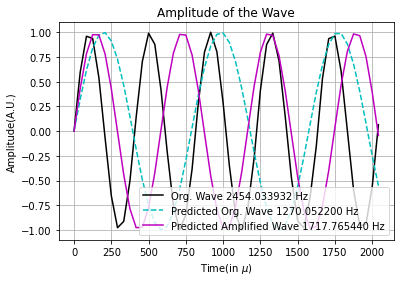

In [ ]:
m = sol.model()
diction = {"x1_" + str(i): 0 for i in range(50)}
# print(diction)
for d in m.decls():
    if d.name() in diction.keys():
        diction[d.name()] = float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))


lst = []
for i in diction.keys():
    lst.append(diction[i])

diction = {"x2_" + str(i): 0 for i in range(50)}
# print(diction)
for d in m.decls():
    if d.name() in diction.keys():
        diction[d.name()] = float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))


lst1 = []
for i in diction.keys():
    lst1.append(diction[i])
f1 = 0
output = "y1_0"
for d in m.decls():
  if output in d.name():
    f1=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
q = 0
output = "f"
for d in m.decls():
  if output in d.name():
    q=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
f2=0
output = "y2_0"
for d in m.decls():
  if output in d.name():
    f2=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
output = "Amp"
for d in m.decls():
  if output in d.name():
    a=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
print(denorm(f2))
print(denorm(f1))
print(f)
print(a)
plt.plot(t_seq[:50]*10**6,lst,'k',label="Org. Wave %f Hz"%f)
plt.plot(t_seq[:50]*10**6,signal(denorm(f1))[:50],'c--',label="Predicted Org. Wave %f Hz"%denorm(f1))
plt.plot(t_seq[:50]*10**6,signal(denorm(f2))[:50],'m',label="Predicted Amplified Wave %f Hz"%denorm(f2))
plt.grid()
plt.xlabel("Time(in $\mu$)")
plt.ylabel("Amplitude(A.U.)")
plt.legend(loc="lower right")
plt.title("Amplitude of the Wave")
# plt.plot(t_seq[:50], signal(1500)[:50])
plt.show()
#Amp:-1.5

#Verification of properties using continuity of input

## Question 3: Phase Change

if there exists a phase change for a given signal, such that the frequency predicted by the network exceeds the threshold.

In [ ]:
tol=0.1
f= Real('f') #frequency we want to optimise
sol,inp1,inp2,out1,out2 = get_solver_mod(weights) #Simulation of the Trained Neural Network
                                             #complying with Z3
for i in range(50): #constraints that the Amplitude is atmost 1
  sol.add(inp1[i][0]>=-1)
  sol.add(inp1[i][0]<= 1)
  sol.add(inp2[i][0]>=-1)
  sol.add(inp2[i][0]<= 1)
# for continuity of input
for i in range(1,50):
    sol.add(absol_z3(inp1[i][0]-inp1[i-1][0])<=0.1*norm(f)*inp1[i][0])
    sol.add(absol_z3(inp2[i][0]-inp2[i-1][0])<=0.1*norm(f)*inp2[i][0])
sol.add(And(f>=1000,f<=5000))
sol.add(And(inp1[50][0]==1,inp2[50][0]==1))
#sol.add(absol_z3(denorm(out1[0][0])-f) >= (tol*f))
sol.add(absol_z3(denorm(out1[0][0])-denorm(out2[0][0])) >= (tol*denorm(out2[0][0])))

sol.check()

Working on layer: 1 ...
Working on layer: 2 ...
Working on layer: 1 ...
Working on layer: 2 ...


NameError: ignored

In [ ]:
m = sol.model()
diction = {"x1_" + str(i): 0 for i in range(50)}
# print(diction)
for d in m.decls():
    if d.name() in diction.keys():
        diction[d.name()] = float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))


lst = []
for i in diction.keys():
    lst.append(diction[i])

diction = {"x2_" + str(i): 0 for i in range(50)}
# print(diction)
for d in m.decls():
    if d.name() in diction.keys():
        diction[d.name()] = float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))


lst1 = []
for i in diction.keys():
    lst1.append(diction[i])
f1 = 0
output = "y1_0"
for d in m.decls():
  if output in d.name():
    f1=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
q = 0
output = "f"
for d in m.decls():
  if output in d.name():
    q=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
f2=0
output = "y2_0"
for d in m.decls():
  if output in d.name():
    f2=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
print(denorm(f2))
print(denorm(f1))
print(f)
plt.plot(t_seq[:50]*10**6,lst[:50],'k',label="Org. Wave %f Hz"%f)
plt.plot(t_seq[:50]*10**6,signal(denorm(f1))[:50],'c--',label="Predicted Org. Wave %f Hz"%denorm(f1))
plt.plot(t_seq[:50]*10**6,signal(denorm(f2))[:50],'m',label="Predicted Shifted Wave %f Hz"%denorm(f2))
plt.grid()
plt.xlabel("Time(in $\mu$)")
plt.ylabel("Amplitude(A.U.)")
plt.legend(loc="lower right")
plt.title("Phase shift of the Wave")
# plt.plot(t_seq[:50], signal(1500)[:50])
plt.show()

In [ ]:
import math
math.degrees(math.asin(lst[0]))
print(abs(denorm(q)-f)/f*100)

NameError: ignored

the minimum phase change of a given signal, such that the frequency predicted by the network exceeds the threshold.

##Reverse of wave

In [ ]:
tol=0.01
f= Real('f') #frequency we want to optimise
#Simulation of the Trained Neural Network
#complying with Z3
sol,inp,inp2,out,out2 = get_solver_mod(weights)
#sol.add(And(f>=1000,f<=5000))
for i in range(50): #constraints that the Amplitude is atmost 1
  sol.add(inp[i][0]>=-1)
  sol.add(inp[i][0]<= 1)
  sol.add(inp2[i][0]>=-1)
  sol.add(inp2[i][0]<= 1)
sol.add(And(inp[50][0]==1,inp2[50][0]==1))
for i in range(1,50):
    sol.add(absol_z3(inp[i][0]-inp[i-1][0])<=0.1*norm(f)*inp[i][0])
    sol.add(absol_z3(inp2[i][0]-inp2[i-1][0])<=0.1*norm(f)*inp2[i][0])
sol.add(absol_z3(denorm(out[0][0])-denorm(out2[0][0])) >= (tol*denorm(out[0][0])))
for j in range(50):
  sol.add(inp[49-j][0]==inp2[j][0])
print(sol.check())

Working on layer: 1 ...
Working on layer: 2 ...
Working on layer: 1 ...
Working on layer: 2 ...
unknown


4083.39508
3859.81468
4791.592865760128


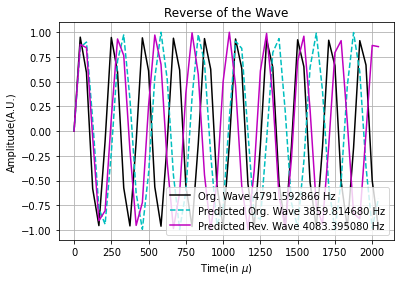

In [ ]:
m = sol.model()
diction = {"x1_" + str(i): 0 for i in range(50)}
# print(diction)
for d in m.decls():
    if d.name() in diction.keys():
        diction[d.name()] = float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))


lst = []
for i in diction.keys():
    lst.append(diction[i])

diction = {"x2_" + str(i): 0 for i in range(50)}
# print(diction)
for d in m.decls():
    if d.name() in diction.keys():
        diction[d.name()] = float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))


lst1 = []
for i in diction.keys():
    lst1.append(diction[i])
f1 = 0
output = "y1_0"
for d in m.decls():
  if output in d.name():
    f1=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
q = 0
output = "f"
for d in m.decls():
  if output in d.name():
    q=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
f2=0
output = "y2_0"
for d in m.decls():
  if output in d.name():
    f2=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
print(denorm(f2))
print(denorm(f1))
print(f)
plt.plot(t_seq[:50]*10**6,lst,'k',label="Org. Wave %f Hz"%f)
plt.plot(t_seq[:50]*10**6,signal(denorm(f1))[:50],'c--',label="Predicted Org. Wave %f Hz"%denorm(f1))
plt.plot(t_seq[:50]*10**6,signal(denorm(f2))[:50],'m',label="Predicted Rev. Wave %f Hz"%denorm(f2))
plt.grid()
plt.xlabel("Time(in $\mu$)")
plt.ylabel("Amplitude(A.U.)")
plt.legend(loc="lower right")
plt.title("Reverse of the Wave")
# plt.plot(t_seq[:50], signal(1500)[:50])
plt.show()

##Flipping the signal

In [ ]:
tol=0.01
#f= Real('f') #frequency we want to optimise
#Simulation of the Trained Neural Network
#complying with Z3
sol,inp,inp2,out,out2 = get_solver_mod(weights)

for i in range(50): #constraints that the Amplitude is atmost 1
  sol.add(inp[i][0]>=-1)
  sol.add(inp[i][0]<= 1)
  sol.add(inp2[i][0]>=-1)
  sol.add(inp2[i][0]<= 1)
for i in range(1,50):
    sol.add(absol_z3(inp[i][0]-inp[i-1][0])<=0.1*norm(f)*inp[i][0])
    sol.add(absol_z3(inp2[i][0]-inp2[i-1][0])<=0.1*norm(f)*inp2[i][0])
sol.add(And(inp[50][0]==1,inp2[50][0]==1))
sol.add(absol_z3(denorm(out[0][0])-denorm(out2[0][0])) >= (tol*denorm(out[0][0])))
for i in range(50):
  sol.add(inp[i][0]==-inp2[i][0])
print(sol.check())

Working on layer: 1 ...
Working on layer: 2 ...
Working on layer: 1 ...
Working on layer: 2 ...
sat


3635.2118
3437.60156
0


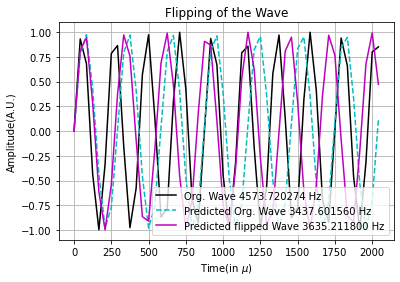

In [ ]:
m = sol.model()
diction = {"x1_" + str(i): 0 for i in range(50)}
# print(diction)
for d in m.decls():
    if d.name() in diction.keys():
        diction[d.name()] = float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))


lst = []
for i in diction.keys():
    lst.append(diction[i])

diction = {"x2_" + str(i): 0 for i in range(50)}
# print(diction)
for d in m.decls():
    if d.name() in diction.keys():
        diction[d.name()] = float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))


lst1 = []
for i in diction.keys():
    lst1.append(diction[i])
f1 = 0
output = "y1_0"
for d in m.decls():
  if output in d.name():
    f1=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
q = 0
output = "f"
for d in m.decls():
  if output in d.name():
    q=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
f2=0
output = "y2_0"
for d in m.decls():
  if output in d.name():
    f2=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
print(denorm(f2))
print(denorm(f1))
print(q)
plt.plot(t_seq[:50]*10**6,lst[:50],'k',label="Org. Wave %f Hz"%f)
plt.plot(t_seq[:50]*10**6,signal(denorm(f1))[:50],'c--',label="Predicted Org. Wave %f Hz"%denorm(f1))
plt.plot(t_seq[:50]*10**6,signal(denorm(f2))[:50],'m',label="Predicted flipped Wave %f Hz"%denorm(f2))
plt.grid()
plt.xlabel("Time(in $\mu$)")
plt.ylabel("Amplitude(A.U.)")
plt.legend(loc="lower right")
plt.title("Flipping of the Wave")
# plt.plot(t_seq[:50], signal(1500)[:50])
plt.show()

##Maximum amplitude

In [ ]:
tol=0.1
#f= Real('f') #frequency we want to optimise
#Simulation of the Trained Neural Network
#complying with Z3
sol,inp,inp2,out,out2 = get_solver_mod(weights)
sol.add(And(inp[50][0]==1,inp2[50][0]==1))
A=Real('Amp')
sol.add(Or(And(A<=5,A>=1.2),And(A>.2,A<=.8)))
for i in range(50): #constraints that the Amplitude is atmost 1
  sol.add(inp[i][0]>=-A)
  sol.add(inp[i][0]<= A)
  sol.add(inp2[i][0]>=-A)
  sol.add(inp2[i][0]<= A)
for i in range(1,50):
    sol.add(absol_z3(inp1[i][0]-inp1[i-1][0])<=0.1*norm(f)*inp1[i][0])
    sol.add(absol_z3(inp2[i][0]-inp2[i-1][0])<=0.1*norm(f)*inp2[i][0])
for j in range(50):
  sol.add(inp[j][0]==A*inp2[j][0])
sol.add(absol_z3(denorm(out[0][0])-denorm(out2[0][0])) >= (tol*denorm(out[0][0])))
print(sol.check())

Working on layer: 1 ...
Working on layer: 2 ...
Working on layer: 1 ...
Working on layer: 2 ...
sat


1717.7654400000001
1270.0522
2454.0339323224953
2.0


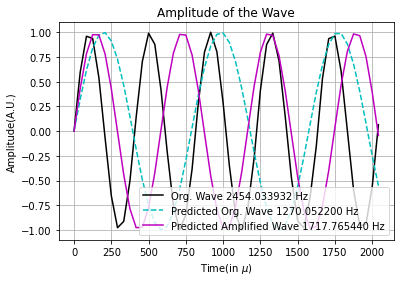

In [ ]:
m = sol.model()
diction = {"x1_" + str(i): 0 for i in range(50)}
# print(diction)
for d in m.decls():
    if d.name() in diction.keys():
        diction[d.name()] = float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))


lst = []
for i in diction.keys():
    lst.append(diction[i])

diction = {"x2_" + str(i): 0 for i in range(50)}
# print(diction)
for d in m.decls():
    if d.name() in diction.keys():
        diction[d.name()] = float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))


lst1 = []
for i in diction.keys():
    lst1.append(diction[i])
f1 = 0
output = "y1_0"
for d in m.decls():
  if output in d.name():
    f1=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
q = 0
output = "f"
for d in m.decls():
  if output in d.name():
    q=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
f2=0
output = "y2_0"
for d in m.decls():
  if output in d.name():
    f2=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
output = "Amp"
for d in m.decls():
  if output in d.name():
    a=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
print(denorm(f2))
print(denorm(f1))
print(f)
print(a)
plt.plot(t_seq[:50]*10**6,lst,'k',label="Org. Wave %f Hz"%f)
plt.plot(t_seq[:50]*10**6,signal(denorm(f1))[:50],'c--',label="Predicted Org. Wave %f Hz"%denorm(f1))
plt.plot(t_seq[:50]*10**6,signal(denorm(f2))[:50],'m',label="Predicted Amplified Wave %f Hz"%denorm(f2))
plt.grid()
plt.xlabel("Time(in $\mu$)")
plt.ylabel("Amplitude(A.U.)")
plt.legend(loc="lower right")
plt.title("Amplitude of the Wave")
# plt.plot(t_seq[:50], signal(1500)[:50])
plt.show()
#Amp:-1.5

In [ ]:
m = sol.model()
diction = {"x_" + str(i): 0 for i in range(50)}
# print(diction)
for d in m.decls():
    if d.name() in diction.keys():
        diction[d.name()] = float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))


lst = []
for i in diction.keys():
    lst.append(diction[i])
a = 0
output = "Amp"
for d in m.decls():
  if output in d.name():
    a=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
f = 0
output = "f"
for d in m.decls():
  if output in d.name():
    f=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
q = 0
output = "y_0"
for d in m.decls():
  if output in d.name():
    q=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
print(f,denorm(q))
plt.plot(t_seq[:50]*10**6,signal(denorm(q))[:50],'k',label="Output Wave")
plt.plot(t_seq[:50]*10**6,signal(f,a)[:50],'o--',label="Original Wave")
plt.plot(t_seq[:50]*10**6,lst,'y--',label="Input Wave")
plt.xlabel("Time(in $\mu$)")
plt.ylabel("Amplitude(A.U.)")
plt.legend(loc="upper right")
plt.title("Flipping of wave")
# plt.plot(t_seq[:50], signal(1500)[:50])
plt.show()
#input freq:2685.7419332, output:2859.3808

In [ ]:
tol=0.05
#f= Real('f') #frequency we want to optimise
opt,sol,inp,out = get_solver(weights,biases) #Simulation of the Trained Neural Network
                                             #complying with Z3
#val = random.randint(1000,5000)
#frac = random.uniform(0,1)
#f = val+frac
A1=Real('Amplitude')
f = Real('f')
sol.add(And(A1 > 0,A1 < 5))
sol.add(Or(A1 <= .8,A1 >= 1.2))
sol.add(And(f<=3000,f>=1000))
for i in range(50): #constraints that the Amplitude is atmost 1
  sol.add(inp[i][0]>=-2)
  sol.add(inp[i][0]<= 2)

T = Real('T') #time interval between 2 sampling points
sol.add(T == 1/24000)
step = Real('step')
sol.add(step == 6.28318*f*T)
old_v = 0
v1=old_v
for i in range(50):
    sol.add(inp[i][0] ==A1* z3sinx(v1))
    v = Real('v_' + str(i)) #stores the shifted signal
    sol.add(v == (old_v + step))
    v1 = If(v >= 6.28318, v-6.28318, v)
    old_v = v1
sol.add(absol_z3(denorm(out[0][0])-f) <= (tol*f))
sol.check()

In [ ]:
m = sol.model()
diction = {"x_" + str(i): 0 for i in range(50)}
# print(diction)
for d in m.decls():
    if d.name() in diction.keys():
        diction[d.name()] = float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
amm = 0
output = "Amplitude"
for d in m.decls():
  if output in d.name():
    amm=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
lst = []
for i in diction.keys():
    lst.append(diction[i])
f = 0
output = "f"
for d in m.decls():
  if output in d.name():
    f=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
q = 0
output = "y_0"
for d in m.decls():
  if output in d.name():
    q=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
print(f,denorm(q),amm)
plt.plot(t_seq[:50]*10**6,signal(denorm(q))[:50],'k',label="Output Wave")
plt.plot(t_seq[:50]*10**6,signal(f)[:50],'o--',label="Original Wave")
plt.plot(t_seq[:50]*10**6,lst,'y--',label="Input Wave")
plt.xlabel("Time(in $\mu$)")
plt.ylabel("Amplitude(A.U.)")
plt.legend(loc="upper right")
plt.title("Flipping of wave")
# plt.plot(t_seq[:50], signal(1500)[:50])
plt.show()
#input freq:2685.7419332, output:2859.3808

In [ ]:
tol=0.05
thresh=0.2
#frequency we want to optimise
opt,sol,inp,out = get_solver(weights,biases) #Simulation of the Trained Neural Network
                                             #complying with Z3
val = randint(1000,5000)
frac = random.uniform(0,1)
f = val+frac
org_inp = Adding_noise(signal(f))[:50]

for i in range(50): #constraints that the Amplitude is atmost 1
  sol.add(inp[i][0]>=-5)
  sol.add(inp[i][0]<= 5)

sol.add(out[0][0]==f)
#sol.add(And(f1>=5000,f1<=5000)) #range of the frequency
#sol.add(absol_z3(f2-f1) >= thresh*f1)
T = Real('T') #time interval between 2 sampling points
sol.add(T == 1/24000)
step = Real('step')
sol.add(step == 6.28318*f*T)
old_v = Real('oldv')
v1= old_v
sol.add(And(old_v > 0, old_v <= 6.28318))
for i in range(50):
    sol.add(inp[i][0] == z3sinx(v1))
    sol.add(inp)
    v2 = Real('v_' + str(i)) #stores the shifted signal
    sol.add(v == (old_v + step))
    v12 = If(v2 >= 6.28318, v2-6.28318, v2)
    old_v2 = v12
sol.check()

In [ ]:
m = sol.model()
diction = {"x_" + str(i): 0 for i in range(50)}
# print(diction)
for d in m.decls():
    if d.name() in diction.keys():
        diction[d.name()] = float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))


lst = []
for i in diction.keys():
    lst.append(diction[i])
f = 0
output = "f"
for d in m.decls():
  if output in d.name():
    f=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
A = 0
output = "Amplitude"
for d in m.decls():
  if output in d.name():
    A=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
s = 0
output = "Amplitude"
for d in m.decls():
  if output in d.name():
    A=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
q = 0
output = "y_0"
for d in m.decls():
  if output in d.name():
    q=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))

print(f)
plt.plot(t_seq[:50]*10**6,lst,'y--',label="Input Wave")
plt.plot(t_seq[:50]*10**6,signal(f,A)[:50],'o--',label="Original Wave")
plt.plot(t_seq[:50]*10**6,signal(denorm(q),A)[:50],'k',label="Output Wave")
plt.grid()
plt.xlabel("Time(in $\mu$)")
plt.ylabel("Amplitude(A.U.)")
plt.legend(loc="lower right")
plt.title("Phase Shift")
# plt.plot(t_seq[:50], signal(1500)[:50])
plt.show()

In [ ]:
def incdec(pnweights):
  new_weights=pnweights.pop()
  for i in reversed(pnweights[:-1]):

#Verification of properties using approximated sinewave

## Question 3: Phase Change

In [ ]:
import random
from random import randint

if there exists a phase change for a given signal, such that the frequency predicted by the network exceeds the threshold.

In [ ]:
tol=0.1
f= Real('f') #frequency we want to optimise
sol,inp1,inp2,out1,out2 = get_solver_mod(weights) #Simulation of the Trained Neural Network
                                             #complying with Z3
for i in range(50): #constraints that the Amplitude is atmost 1
  sol.add(inp1[i][0]>=-1)
  sol.add(inp1[i][0]<= 1)
  sol.add(inp2[i][0]>=-1)
  sol.add(inp2[i][0]<= 1)
sol.add(And(f>=3000,f<=3500))

T = Real('T') #time interval between 2 sampling points
sol.add(T == 1/24000)
step = Real('step')
sol.add(step == 6.28318*f*T)

old_v = Real('oldv')
v1 = old_v
sol.add(And(old_v > 0, old_v <= 6.28318))
for i in range(50):
    sol.add(inp1[i][0] == z3sinx(v1))
    v = Real('v_' + str(i)) #stores the shifted signal
    sol.add(v == (old_v + step))
    v1 = If(v >= 6.28318, v-6.28318, v)
    old_v = v1
#sol.add(absol_z3(denorm(out1[0][0])-f) >= (tol*f))

new_v =Real('new_v')
sol.add(new_v==0)
v2 = new_v
for j in range(50):
    sol.add(inp2[j][0] == z3sinx(v2))
    v0 = Real('v0_' + str(j)) #stores the shifted signal
    sol.add(v0 == (new_v + step))
    v2 = If(v0 >= 6.28318, v0-6.28318, v0)
    new_v = v2
sol.add(absol_z3(denorm(out1[0][0])-denorm(out2[0][0])) >= (tol*denorm(out2[0][0])))

sol.check()

Working on layer: 1 ...
Working on layer: 2 ...
Working on layer: 1 ...
Working on layer: 2 ...


sat

3799.07708
3414.69412
4840.362462631239


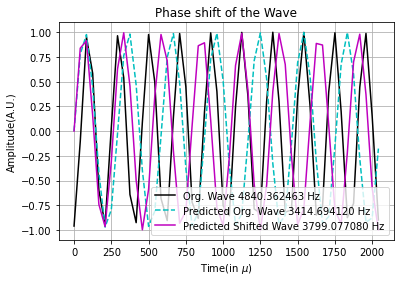

In [ ]:
m = sol.model()
diction = {"x1_" + str(i): 0 for i in range(50)}
# print(diction)
for d in m.decls():
    if d.name() in diction.keys():
        diction[d.name()] = float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))


lst = []
for i in diction.keys():
    lst.append(diction[i])

diction = {"x2_" + str(i): 0 for i in range(50)}
# print(diction)
for d in m.decls():
    if d.name() in diction.keys():
        diction[d.name()] = float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))


lst1 = []
for i in diction.keys():
    lst1.append(diction[i])
f1 = 0
output = "y1_0"
for d in m.decls():
  if output in d.name():
    f1=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
q = 0
output = "f"
for d in m.decls():
  if output in d.name():
    q=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
f2=0
output = "y2_0"
for d in m.decls():
  if output in d.name():
    f2=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
print(denorm(f2))
print(denorm(f1))
print(f)
plt.plot(t_seq[:50]*10**6,lst[:50],'k',label="Org. Wave %f Hz"%f)
plt.plot(t_seq[:50]*10**6,signal(denorm(f1))[:50],'c--',label="Predicted Org. Wave %f Hz"%denorm(f1))
plt.plot(t_seq[:50]*10**6,signal(denorm(f2))[:50],'m',label="Predicted Shifted Wave %f Hz"%denorm(f2))
plt.grid()
plt.xlabel("Time(in $\mu$)")
plt.ylabel("Amplitude(A.U.)")
plt.legend(loc="lower right")
plt.title("Phase shift of the Wave")
# plt.plot(t_seq[:50], signal(1500)[:50])
plt.show()

In [ ]:
import math
math.degrees(math.asin(lst[0]))
print(abs(denorm(q)-f)/f*100)

the minimum phase change of a given signal, such that the frequency predicted by the network exceeds the threshold.

##Reverse of wave

###Using CEGAR Algorithm

In [ ]:
#test reversal (when range was limited to 4000-5000Hz)
c=Check()
my_cegar(weights,c)

Abstracted model obtained:
 [{'PI': [[0, 2, 5, 6, 8]], 'PD': [[]], 'ND': [[1, 3, 4, 7]], 'NI': [[]]}]
Working on model............
Counter example :  [ 0.          0.96480149  0.50744547 -0.69793818 -0.87862505  0.23795273
  0.99966587  0.28782983 -0.84836673 -0.74276039  0.46223591  0.97710291
  0.05167903 -0.95014774 -0.56940438  0.65996524  0.89840877 -0.18744162
 -0.9975498  -0.37318967  0.81978185  0.76810417 -0.41579771 -0.98809644
 -0.17379382  0.93250484  0.59367463 -0.62027695 -0.92283727  0.13643067
  0.99165866  0.3851405  -0.78914784 -0.80652574  0.36823973  0.99384513
  0.15448119 -0.91274554 -0.64777369  0.57889469  0.93893865 -0.08505318
 -0.98405207 -0.4593036   0.75629415  0.83009339 -0.31970362 -0.99914997
 -0.25849145  0.89024715  1.        ]
Valid counter example


'Not hold'

###Without using CEGAR Algorithm

Here we have increased our tolerance and checking for negation of the property

In [ ]:
tol=0.2
f= Real('f') #frequency we want to optimise
#Simulation of the Trained Neural Network
#complying with Z3
sol,inp,inp2,out,out2 = get_solver_mod(weights)
sol.add(And(inp[50][0]==1,inp2[50][0]==1))

for i in range(50): #constraints that the Amplitude is atmost 1
  sol.add(inp[i][0]>=-1)
  sol.add(inp[i][0]<= 1)
  sol.add(inp2[i][0]>=-1)
  sol.add(inp2[i][0]<= 1)

val = random.randint(1000,5000)
frac = random.uniform(0,1)
#f = val+frac

sol.add(And(f>=4500,f<=5000))
#time interval between 2 sampling points
step = 6.28318*f*1/24000
v1= old_v = 0
for i in range(50):
    sol.add(inp[i][0] == z3sinx(v1))
    v = Real('v_' + str(i)) #stores the shifted signal
    sol.add(v == (old_v + step))
    v1 = If(v >= 6.28318, v-6.28318, v)
    old_v = v1
sol.add(Not(Exists(out2[0][0],absol_z3(denorm(out[0][0])-denorm(out2[0][0])) >= (tol*denorm(out[0][0])))))
for j in range(50):
  sol.add(inp[49-j][0]==inp2[j][0])
print(sol.check())

Working on model............


4083.39508
3859.81468
4791.592865760128


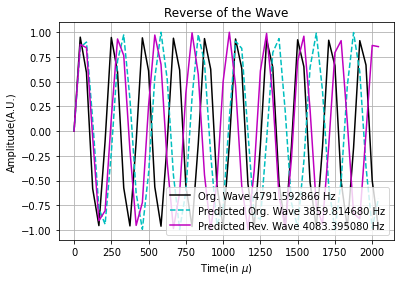

In [ ]:
m = sol.model()
diction = {"x1_" + str(i): 0 for i in range(50)}
# print(diction)
for d in m.decls():
    if d.name() in diction.keys():
        diction[d.name()] = float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))


lst = []
for i in diction.keys():
    lst.append(diction[i])

diction = {"x2_" + str(i): 0 for i in range(50)}
# print(diction)
for d in m.decls():
    if d.name() in diction.keys():
        diction[d.name()] = float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))


lst1 = []
for i in diction.keys():
    lst1.append(diction[i])
f1 = 0
output = "y1_0"
for d in m.decls():
  if output in d.name():
    f1=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
q = 0
output = "f"
for d in m.decls():
  if output in d.name():
    q=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
f2=0
output = "y2_0"
for d in m.decls():
  if output in d.name():
    f2=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
print(denorm(f2))
print(denorm(f1))
print(f)
plt.plot(t_seq[:50]*10**6,lst,'k',label="Org. Wave %f Hz"%f)
plt.plot(t_seq[:50]*10**6,signal(denorm(f1))[:50],'c--',label="Predicted Org. Wave %f Hz"%denorm(f1))
plt.plot(t_seq[:50]*10**6,signal(denorm(f2))[:50],'m',label="Predicted Rev. Wave %f Hz"%denorm(f2))
plt.grid()
plt.xlabel("Time(in $\mu$)")
plt.ylabel("Amplitude(A.U.)")
plt.legend(loc="lower right")
plt.title("Reverse of the Wave")
# plt.plot(t_seq[:50], signal(1500)[:50])
plt.show()

##Flipping the signal

In [ ]:
tol=0.01
#f= Real('f') #frequency we want to optimise
#Simulation of the Trained Neural Network
#complying with Z3
sol,inp,inp2,out,out2 = get_solver_mod(weights)

for i in range(50): #constraints that the Amplitude is atmost 1
  sol.add(inp[i][0]>=-1)
  sol.add(inp[i][0]<= 1)
  sol.add(inp2[i][0]>=-1)
  sol.add(inp2[i][0]<= 1)
 
val = random.randint(1000,5000)
frac = random.uniform(0,1)
f = val+frac
#sol.add(And(f>=1000,f<=5000))
#time interval between 2 sampling points
step = 6.28318*f*1/24000
v1= old_v = 0
for i in range(50):
    sol.add(inp[i][0] == z3sinx(v1))
    v = Real('v_' + str(i)) #stores the shifted signal
    sol.add(v == (old_v + step))
    v1 = If(v >= 6.28318, v-6.28318, v)
    old_v = v1
sol.add(absol_z3(denorm(out[0][0])-denorm(out2[0][0])) >= (tol*denorm(out[0][0])))
for i in range(50):
  sol.add(inp[i][0]==-inp2[i][0])
print(sol.check())

Working on layer: 1 ...
Working on layer: 2 ...
Working on layer: 1 ...
Working on layer: 2 ...
sat


3635.2118
3437.60156
0


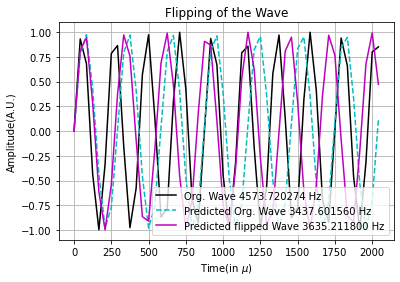

In [ ]:
m = sol.model()
diction = {"x1_" + str(i): 0 for i in range(50)}
# print(diction)
for d in m.decls():
    if d.name() in diction.keys():
        diction[d.name()] = float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))


lst = []
for i in diction.keys():
    lst.append(diction[i])

diction = {"x2_" + str(i): 0 for i in range(50)}
# print(diction)
for d in m.decls():
    if d.name() in diction.keys():
        diction[d.name()] = float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))


lst1 = []
for i in diction.keys():
    lst1.append(diction[i])
f1 = 0
output = "y1_0"
for d in m.decls():
  if output in d.name():
    f1=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
q = 0
output = "f"
for d in m.decls():
  if output in d.name():
    q=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
f2=0
output = "y2_0"
for d in m.decls():
  if output in d.name():
    f2=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
print(denorm(f2))
print(denorm(f1))
print(q)
plt.plot(t_seq[:50]*10**6,lst[:50],'k',label="Org. Wave %f Hz"%f)
plt.plot(t_seq[:50]*10**6,signal(denorm(f1))[:50],'c--',label="Predicted Org. Wave %f Hz"%denorm(f1))
plt.plot(t_seq[:50]*10**6,signal(denorm(f2))[:50],'m',label="Predicted flipped Wave %f Hz"%denorm(f2))
plt.grid()
plt.xlabel("Time(in $\mu$)")
plt.ylabel("Amplitude(A.U.)")
plt.legend(loc="lower right")
plt.title("Flipping of the Wave")
# plt.plot(t_seq[:50], signal(1500)[:50])
plt.show()

##Maximum amplitude

In [ ]:
tol=0.1
#f= Real('f') #frequency we want to optimise
#Simulation of the Trained Neural Network
#complying with Z3
sol,inp,inp2,out,out2 = get_solver_mod(weights)

for i in range(50): #constraints that the Amplitude is atmost 1
  sol.add(inp[i][0]>=-1)
  sol.add(inp[i][0]<= 1)
  sol.add(inp2[i][0]>=-1)
  sol.add(inp2[i][0]<= 1)
A=Real('Amp')
sol.add(Or(And(A<=5,A>=1.2),And(A>.2,A<=.8)))
val = random.randint(1000,5000)
frac = random.uniform(0,1)
f = val+frac
#sol.add(And(f>=1500,f<=2000))
#time interval between 2 sampling points
step = 6.28318*f*1/24000
v1= old_v = 0
for i in range(50):
    sol.add(inp[i][0] == z3sinx(v1))
    v = Real('v_' + str(i)) #stores the shifted signal
    sol.add(v == (old_v + step))
    v1 = If(v >= 6.28318, v-6.28318, v)
    old_v = v1
for j in range(50):
  sol.add(inp[j][0]==A*inp2[j][0])
sol.add(absol_z3(denorm(out[0][0])-denorm(out2[0][0])) >= (tol*denorm(out[0][0])))
print(sol.check())

Working on layer: 1 ...
Working on layer: 2 ...
Working on layer: 1 ...
Working on layer: 2 ...
sat


1717.7654400000001
1270.0522
2454.0339323224953
2.0


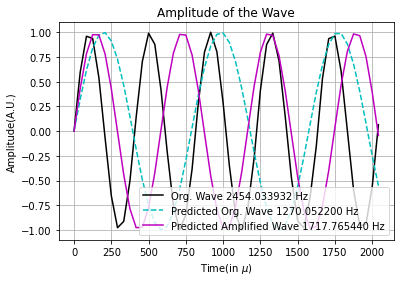

In [ ]:
m = sol.model()
diction = {"x1_" + str(i): 0 for i in range(50)}
# print(diction)
for d in m.decls():
    if d.name() in diction.keys():
        diction[d.name()] = float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))


lst = []
for i in diction.keys():
    lst.append(diction[i])

diction = {"x2_" + str(i): 0 for i in range(50)}
# print(diction)
for d in m.decls():
    if d.name() in diction.keys():
        diction[d.name()] = float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))


lst1 = []
for i in diction.keys():
    lst1.append(diction[i])
f1 = 0
output = "y1_0"
for d in m.decls():
  if output in d.name():
    f1=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
q = 0
output = "f"
for d in m.decls():
  if output in d.name():
    q=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
f2=0
output = "y2_0"
for d in m.decls():
  if output in d.name():
    f2=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
output = "Amp"
for d in m.decls():
  if output in d.name():
    a=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
print(denorm(f2))
print(denorm(f1))
print(f)
print(a)
plt.plot(t_seq[:50]*10**6,lst,'k',label="Org. Wave %f Hz"%f)
plt.plot(t_seq[:50]*10**6,signal(denorm(f1))[:50],'c--',label="Predicted Org. Wave %f Hz"%denorm(f1))
plt.plot(t_seq[:50]*10**6,signal(denorm(f2))[:50],'m',label="Predicted Amplified Wave %f Hz"%denorm(f2))
plt.grid()
plt.xlabel("Time(in $\mu$)")
plt.ylabel("Amplitude(A.U.)")
plt.legend(loc="lower right")
plt.title("Amplitude of the Wave")
# plt.plot(t_seq[:50], signal(1500)[:50])
plt.show()
#Amp:-1.5

In [ ]:
m = sol.model()
diction = {"x_" + str(i): 0 for i in range(50)}
# print(diction)
for d in m.decls():
    if d.name() in diction.keys():
        diction[d.name()] = float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))


lst = []
for i in diction.keys():
    lst.append(diction[i])
a = 0
output = "Amp"
for d in m.decls():
  if output in d.name():
    a=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
f = 0
output = "f"
for d in m.decls():
  if output in d.name():
    f=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
q = 0
output = "y_0"
for d in m.decls():
  if output in d.name():
    q=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
print(f,denorm(q))
plt.plot(t_seq[:50]*10**6,signal(denorm(q))[:50],'k',label="Output Wave")
plt.plot(t_seq[:50]*10**6,signal(f,a)[:50],'o--',label="Original Wave")
plt.plot(t_seq[:50]*10**6,lst,'y--',label="Input Wave")
plt.xlabel("Time(in $\mu$)")
plt.ylabel("Amplitude(A.U.)")
plt.legend(loc="upper right")
plt.title("Flipping of wave")
# plt.plot(t_seq[:50], signal(1500)[:50])
plt.show()
#input freq:2685.7419332, output:2859.3808

In [ ]:
tol=0.5
#f= Real('f') #frequency we want to optimise
opt,sol,inp,out = get_solver(weights,biases) #Simulation of the Trained Neural Network
                                             #complying with Z3
#val = random.randint(1000,5000)
#frac = random.uniform(0,1)
#f = val+frac
A1=Real('Amplitude')
f = Real('f')
sol.add(And(A1 > 0,A1 < 5))
sol.add(Or(A1 <= .8,A1 >= 1.2))
sol.add(And(f<=3000,f>=1000))
for i in range(50): #constraints that the Amplitude is atmost 1
  sol.add(inp[i][0]>=-2)
  sol.add(inp[i][0]<= 2)

T = Real('T') #time interval between 2 sampling points
sol.add(T == 1/24000)
step = Real('step')
sol.add(step == 6.28318*f*T)
old_v = 0
v1=old_v
for i in range(50):
    sol.add(inp[i][0] ==A1* z3sinx(v1))
    v = Real('v_' + str(i)) #stores the shifted signal
    sol.add(v == (old_v + step))
    v1 = If(v >= 6.28318, v-6.28318, v)
    old_v = v1
sol.add(absol_z3(denorm(out[0][0])-f) <= (tol*f))
sol.check()

In [ ]:
m = sol.model()
diction = {"x_" + str(i): 0 for i in range(50)}
# print(diction)
for d in m.decls():
    if d.name() in diction.keys():
        diction[d.name()] = float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
amm = 0
output = "Amplitude"
for d in m.decls():
  if output in d.name():
    amm=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
lst = []
for i in diction.keys():
    lst.append(diction[i])
f = 0
output = "f"
for d in m.decls():
  if output in d.name():
    f=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
q = 0
output = "y_0"
for d in m.decls():
  if output in d.name():
    q=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
print(f,denorm(q),amm)
plt.plot(t_seq[:50]*10**6,signal(denorm(q))[:50],'k',label="Output Wave")
plt.plot(t_seq[:50]*10**6,signal(f)[:50],'o--',label="Original Wave")
plt.plot(t_seq[:50]*10**6,lst,'y--',label="Input Wave")
plt.xlabel("Time(in $\mu$)")
plt.ylabel("Amplitude(A.U.)")
plt.legend(loc="upper right")
plt.title("Flipping of wave")
# plt.plot(t_seq[:50], signal(1500)[:50])
plt.show()
#input freq:2685.7419332, output:2859.3808

In [ ]:
tol=0.05
thresh=0.2
#frequency we want to optimise
opt,sol,inp,out = get_solver(weights,biases) #Simulation of the Trained Neural Network
                                             #complying with Z3
val = randint(1000,5000)
frac = random.uniform(0,1)
f = val+frac
org_inp = Adding_noise(signal(f))[:50]

for i in range(50): #constraints that the Amplitude is atmost 1
  sol.add(inp[i][0]>=-5)
  sol.add(inp[i][0]<= 5)

sol.add(out[0][0]==f)
#sol.add(And(f1>=5000,f1<=5000)) #range of the frequency
#sol.add(absol_z3(f2-f1) >= thresh*f1)
T = Real('T') #time interval between 2 sampling points
sol.add(T == 1/24000)
step = Real('step')
sol.add(step == 6.28318*f*T)
old_v = Real('oldv')
v1= old_v
sol.add(And(old_v > 0, old_v <= 6.28318))
for i in range(50):
    sol.add(inp[i][0] == z3sinx(v1))
    sol.add(inp)
    v2 = Real('v_' + str(i)) #stores the shifted signal
    sol.add(v == (old_v + step))
    v12 = If(v2 >= 6.28318, v2-6.28318, v2)
    old_v2 = v12
sol.check()

In [ ]:
m = sol.model()
diction = {"x_" + str(i): 0 for i in range(50)}
# print(diction)
for d in m.decls():
    if d.name() in diction.keys():
        diction[d.name()] = float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))


lst = []
for i in diction.keys():
    lst.append(diction[i])
f = 0
output = "f"
for d in m.decls():
  if output in d.name():
    f=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
A = 0
output = "Amplitude"
for d in m.decls():
  if output in d.name():
    A=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
s = 0
output = "Amplitude"
for d in m.decls():
  if output in d.name():
    A=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))
q = 0
output = "y_0"
for d in m.decls():
  if output in d.name():
    q=float(m[d].as_decimal(8)[:-1] if m[d].as_decimal(8)[-1] == '?' else  m[d].as_decimal(8))

print(f)
plt.plot(t_seq[:50]*10**6,lst,'y--',label="Input Wave")
plt.plot(t_seq[:50]*10**6,signal(f,A)[:50],'o--',label="Original Wave")
plt.plot(t_seq[:50]*10**6,signal(denorm(q),A)[:50],'k',label="Output Wave")
plt.grid()
plt.xlabel("Time(in $\mu$)")
plt.ylabel("Amplitude(A.U.)")
plt.legend(loc="lower right")
plt.title("Phase Shift")
# plt.plot(t_seq[:50], signal(1500)[:50])
plt.show()

#Taking a higher threshold and verifying the negation of the property to be UNSAT

In [ ]:
print("Checking the Property: If there exists a phase change for a given signal, such that the frequency predicted by the network exceeds the threshold.")
tol=0.5
f= Real('f') #frequency we want to optimise
opt,sol,inp1,out1 = get_solver(weights) #Simulation of the Trained Neural Network
#sol.add(absol_z3(denorm(out1[0][0])-denorm(out2[0][0])) >= (tol*denorm(out2[0][0])))                                             #complying with Z3
for i in range(50): #constraints that the Amplitude is atmost 1
  sol.add(inp1[i][0]>=-1)
  sol.add(inp1[i][0]<= 1)
  sol.add(inp2[i][0]>=-1)
  sol.add(inp2[i][0]<= 1)

T = Real('T') #time interval between 2 sampling points
sol.add(T == 1/24000)
step = Real('step')
sol.add(step == 6.28318*f*T)
old_v = Real('oldv')
v1= old_v
sol.add(And(old_v > 0, old_v <= 6.28318))
for i in range(50):
    sol.add(inp1[i][0] == z3sinx(v1))
    v = Real('v_' + str(i)) #stores the shifted signal
    sol.add(v == (old_v + step))
    v1 = If(v >= 6.28318, v-6.28318, v)
    old_v = v1

#print(f)
sol.add(And(f>=1000,f<=5000))
sol.add(And(inp1[50][0]==1))

sol.add(Not(Exists(out1[0][0],absol_z3(denorm(out1[0][0])-f) >= (tol*f))))

if sol.check()==unsat:
  print("The model complies with the property for a threshold of %f %",tol*100)
else:
  print("There is a phase for which the output goes out of bound")

Checking the Property: If there exists a phase change for a given signal, such that the frequency predicted by the network exceeds the threshold.
Working on model............
